## AirBnB Predictions 

This notebook on predicting housing prices using geospatial techniques for AirBnB listings in New Zealand. The rise of Airbnb and other short-term rental platforms has disrupted the traditional housing market, making it challenging for homeowners and potential renters to estimate fair rental prices. In this notebook, we will explore the possibility of geospatial data and machine learning algorithms to analyze factors that influence rental prices in Auckland, New Zealand.



#### Import Packages and Initial Data

In [4]:
# import necessary starting packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings 
from shapely.geometry import Point
import contextily
import requests 

warnings.filterwarnings("ignore")

import geopandas as gpd
sns.set_theme(context='notebook', style='darkgrid', palette='Set3')


| Field |	Type |	Calculated |	Description |
| ------------ | ----------- | ----- | --------------------: |
| id |	integer |		| Airbnb's unique identifier for the listing |
| name |	string	|	|
| host_id |	integer		| | |
| host_name |	string | | |		
| neighbourhood_group |	text |	y |	The neighbourhood group as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles. |
| neighbourhood | 	text |	y |	The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles. |
| latitude | 	numeric	| |	Uses the World Geodetic System (WGS84) projection for latitude and longitude. |
| longitude | numeric | |			Uses the World Geodetic System (WGS84) projection for latitude and longitude. |
| room_type | 	string | | |		
| price | 	currency |  |		daily price in local currency. Note, $ sign may be used despite locale |
| minimum_nights | 	integer |  |		minimum number of night stay for the listing (calendar rules may be different) |
| number_of_reviews | 	integer |  |		The number of reviews the listing has |
| last_review |	date | 	y |	The date of the last/newest review |
| reviews_per_month | float | | |
| calculated_host_listings_count | 	integer | 	y | 	The number of listings the host has in the current scrape, in the city/region geography. |
availability_365 | 	integer | 	y |	avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may be available because it has been booked by a guest or blocked by the host. | 
| number_of_reviews_ltm | 	integer | 	y | 	The number of reviews the listing has (in the last 12 months) | 


In [5]:
listings = pd.read_csv('listings.csv')
listings.describe()

id       host_id      latitude     longitude          price  \
count  4.302300e+04  4.302300e+04  43023.000000  43023.000000   43023.000000   
mean   2.048146e+17  1.562744e+08    -40.002129    173.715840     371.862144   
std    3.271390e+17  1.340900e+08      3.267737      4.210073    2592.128189   
min    6.113000e+03  2.576000e+03    -46.906730   -176.558530      14.000000   
25%    2.458166e+07  4.898999e+07    -43.498885    172.642315     125.000000   
50%    4.247774e+07  1.221591e+08    -39.067970    174.746490     200.000000   
75%    5.981310e+17  2.265604e+08    -36.917680    175.460818     328.000000   
max    8.431835e+17  5.043445e+08    -34.516090    178.479460  140150.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    43023.000000       43023.000000       38504.000000   
mean         2.897892          50.622992           1.785686   
std         20.560198          85.810740           1.985047   
min          1.000000           0.000000           0.010000   
25%          1.000000           3.000000           0.410000   
50%          2.000000          17.000000           1.100000   
75%          2.000000          59.000000           2.450000   
max       1124.000000        1427.000000          34.410000   

       calculated_host_listings_count  availability_365  \
count                    43023.000000      43023.000000   
mean                       124.265881        175.527206   
std                        497.578875        133.983358   
min                          1.000000          0.000000   
25%                          1.000000         43.000000   
50%                          2.000000        165.000000   
75%                          5.000000        315.000000   
max                       2244.000000        365.000000   

       number_of_reviews_ltm  license  
count           43023.000000      0.0  
mean               14.405992      NaN  
std                21.228856      NaN  
min                 0.000000      NaN  
25%                 1.000000      NaN  
50%                 6.000000      NaN  
75%                20.000000      NaN  
max               433.000000      NaN

Neighborhoods group looks closer to city to me. Most observations are in Auckland

In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43023 entries, 0 to 43022
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              43023 non-null  int64  
 1   name                            43022 non-null  object 
 2   host_id                         43023 non-null  int64  
 3   host_name                       43023 non-null  object 
 4   neighbourhood_group             43023 non-null  object 
 5   neighbourhood                   43023 non-null  object 
 6   latitude                        43023 non-null  float64
 7   longitude                       43023 non-null  float64
 8   room_type                       43023 non-null  object 
 9   price                           43023 non-null  int64  
 10  minimum_nights                  43023 non-null  int64  
 11  number_of_reviews               43023 non-null  int64  
 12  last_review                     

It looks like there are some null value in the reviews section. I will keep these for now since they may be relevant to this analysis. We can see if they disappear when we filt the dataset to the cities we need.

First we can drop a couple fo columns that aren't relevant for us.

In [7]:
listings = listings.drop(columns=['name', 'host_name', 'license'])

In [8]:
listings.groupby('neighbourhood_group')['reviews_per_month'].apply(lambda x: x.isnull().sum()).sort_values(ascending = False)


neighbourhood_group
Auckland                      1169
Queenstown-Lakes District      474
Thames-Coromandel District     314
Christchurch City              268
Tauranga City                  217
                              ... 
Ōtorohanga District              4
Gore District                    3
South Waikato District           3
Kawerau District                 1
Chatham Islands Territory        0
Name: reviews_per_month, Length: 67, dtype: int64

It looks like the null values are evenly spread percentage of the population. I am going to make the assumption that if the reviews month column is N/A then it means there hasn't been a review in the last month and we will coerce it to 0. The last review doesn't seems circumstantial and may not be the most important characteristic so we will drop that.

In [9]:
listings.drop(columns=['last_review'], inplace=True)
listings['reviews_per_month'].fillna(0, inplace=True)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43023 entries, 0 to 43022
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              43023 non-null  int64  
 1   host_id                         43023 non-null  int64  
 2   neighbourhood_group             43023 non-null  object 
 3   neighbourhood                   43023 non-null  object 
 4   latitude                        43023 non-null  float64
 5   longitude                       43023 non-null  float64
 6   room_type                       43023 non-null  object 
 7   price                           43023 non-null  int64  
 8   minimum_nights                  43023 non-null  int64  
 9   number_of_reviews               43023 non-null  int64  
 10  reviews_per_month               43023 non-null  float64
 11  calculated_host_listings_count  43023 non-null  int64  
 12  availability_365                

#### EDA

Awesome the dataset looks to be ready to start our analysis. For this analysis we will use only just the Auckland Area. However let first visualize the data we have and see what that contains.



In [10]:
neighborhoods = gpd.read_file('neighbourhoods.geojson')
neighborhoods = neighborhoods[neighborhoods['neighbourhood']!= 'Area Outside Territorial Authority']

neighborhoods.head(5)

neighbourhood neighbourhood_group  \
0            Waipaoa Ward   Gisborne District   
1       Tawhiti-Uawa Ward   Gisborne District   
2  Taruheru-Patutahi Ward   Gisborne District   
3           Gisborne Ward   Gisborne District   
4     Wairoa General Ward     Wairoa District   

                                            geometry  
0  MULTIPOLYGON (((177.29832 -38.40158, 177.34641...  
1  MULTIPOLYGON (((178.34318 -38.37897, 178.34336...  
2  MULTIPOLYGON (((177.88188 -38.62445, 177.88210...  
3  MULTIPOLYGON (((178.04868 -38.70512, 178.04876...  
4  MULTIPOLYGON (((177.87094 -39.27634, 177.87097...

The GeoJSON comes nicely formatted here so we dont have to do any work with that. However we do need to make a geodataframe from our listings data. First we need to make a geometry column to convert all of our listing to geometric points. 

In [11]:
listings['geometry'] = listings.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)
listings_geo = gpd.GeoDataFrame(listings, geometry=listings.geometry, crs= {'init': 'epsg:4326'})
listings_geo.head(7)

id  host_id        neighbourhood_group             neighbourhood  \
0   6113    12177      Kapiti Coast District               Ōtaki Ward    
1  35325   152089  Queenstown-Lakes District  Queenstown-Wakatipu Ward   
2  46071   202747             Taupo District    Turangi-Tongariro Ward   
3  48443   220702        Horowhenua District            Kere Kere Ward   
4  48445   220702        Horowhenua District            Kere Kere Ward   
5  51362   236005       Marlborough District   Marlborough Sounds Ward   
6  52133   240890                   Auckland               Howick Ward   

   latitude  longitude        room_type  price  minimum_nights  \
0 -40.75807  175.15637     Private room    106               1   
1 -45.00497  168.77567  Entire home/apt    249              21   
2 -38.91049  175.75361  Entire home/apt    229               2   
3 -40.48679  175.35016     Private room    116               1   
4 -40.48485  175.34897     Private room    116               1   
5 -41.19424  174.03270     Private room    245               2   
6 -36.91515  174.93825     Private room    119               1   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0                  0               0.00                               1   
1                 19               0.27                               2   
2                 17               0.39                               1   
3                  0               0.00                               2   
4                  0               0.00                               2   
5                 53               0.48                               1   
6                  0               0.00                               1   

   availability_365  number_of_reviews_ltm                     geometry  
0                 0                      0  POINT (175.15637 -40.75807)  
1                54                      1  POINT (168.77567 -45.00497)  
2               270                      5  POINT (175.75361 -38.91049)  
3                 0                      0  POINT (175.35016 -40.48679)  
4                 0                      0  POINT (175.34897 -40.48485)  
5                38                      9  POINT (174.03270 -41.19424)  
6                 0                      0  POINT (174.93825 -36.91515)

In [12]:
list_grouped = listings.groupby(['neighbourhood_group'])['price'].agg(['median', 'mean', 'count']).\
    sort_values('median', ascending = False)

list_grouped.columns = ['Median', 'Mean', 'Count']
list_grouped.sort_values('Count', ascending = False)



Median        Mean  Count
neighbourhood_group                                  
Auckland                     180.0  328.286291   8177
Queenstown-Lakes District    350.0  506.717692   4697
Christchurch City            150.0  376.083639   2451
Tauranga City                271.0  460.852576   2096
Thames-Coromandel District   250.0  511.390411   1752
...                            ...         ...    ...
Stratford District           138.5  140.571429     42
Gore District                115.0  119.282051     39
Waimate District             150.0  173.514286     35
Kawerau District             137.0  137.857143      7
Chatham Islands Territory    312.5  306.250000      4

[67 rows x 3 columns]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = neighborhoods.plot(color = 'None',edgecolor = 'grey', ax=ax, linewidth = 1)
listings_geo.plot(ax = ax, alpha = .1, color = 'red', markersize = .2)

ax.set_xlim([165, 180])
ax.set_ylim([-50.85, -30.65]) 

plt.title('New Zealand AirBnB listings')
contextily.add_basemap(ax=ax, crs=neighborhoods.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('airbnb_listings.png', dpi=300, bbox_inches='tight')

For this analysis I think we will narrow this down to just Auckland. This will simplify the analysis a bit and make it easier to visualize and analyze. From here we can focus just on the neighbourhoods in the Auckland area. Lets do some visualizations to take a look at the spread throughout the neighbourhood.

In [14]:
# read in sauburb shapefile
df = gpd.read_file('lds-nz-suburbs-and-localities-pilot-SHP.zip')
#filter for just auckland
df = df.query('territor_1 == "Auckland"')
auck_map = df[['id', 'major_name', 'territoria', 'geometry']]
cols = ['id', 'suburb', 'territory', 'geometry']
auck_map.columns = cols
print(auck_map.crs)
auck_map = auck_map.dissolve(by='suburb').reset_index()
auck_map.head(2)

EPSG:4326


suburb                                           geometry    id  \
0   Auckland  MULTIPOLYGON (((174.61575 -36.96564, 174.61565...   140   
1  Big Omaha  POLYGON ((174.69033 -36.29127, 174.69325 -36.2...  8751   

  territory  
0  Auckland  
1  Auckland

In [15]:
auck_listings = listings_geo.query('neighbourhood_group == "Auckland"')
auck_listings.crs = auck_map.crs
print(auck_listings.crs)
auck_listings.head(2)

EPSG:4326


id  host_id neighbourhood_group     neighbourhood  latitude  longitude  \
6   52133   240890            Auckland       Howick Ward -36.91515  174.93825   
14  86839   475889            Auckland  North Shore Ward -36.78811  174.68541   

       room_type  price  minimum_nights  number_of_reviews  reviews_per_month  \
6   Private room    119               1                  0                0.0   
14  Private room     52               2                  0                0.0   

    calculated_host_listings_count  availability_365  number_of_reviews_ltm  \
6                                1                 0                      0   
14                               1                 0                      0   

                       geometry  
6   POINT (174.93825 -36.91515)  
14  POINT (174.68541 -36.78811)

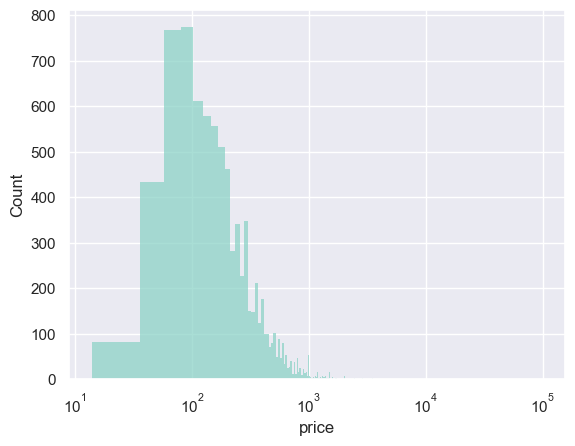

In [16]:
sns.histplot(data = auck_listings, x = 'price')
plt.xscale('log')

In [17]:
auck_listings = gpd.sjoin(auck_listings,auck_map, predicate = 'within')
auck_listings.suburb.value_counts()

Auckland                               5664
Waiheke Island                          750
Whangaparaoa                            154
Warkworth                               122
Orewa                                    92
Great Barrier Island (Aotea Island)      89
Papakura                                 89
Matakana                                 79
Piha                                     62
Red Beach                                55
Wellsford                                55
Snells Beach                             52
Omaha                                    50
Silverdale                               40
Muriwai                                  40
Drury                                    33
Leigh                                    33
Point Wells                              33
Takanini                                 31
Bombay                                   30
Dairy Flat                               27
Riverhead                                27
Clevedon                        

In [18]:
# Set up API keys and client
with open('/Users/laffer/Desktop/IoD/Projects/yelp_key.txt', 'r') as file:
    key = file.readline().strip()
with open('/Users/laffer/Desktop/IoD/Projects/yelp_client.txt', 'r') as file:
    client = file.readline().strip()
    
unique_businesses = set()  

yelp_beaches = pd.DataFrame()
for i in range(5):
    url = 'https://api.yelp.com/v3/businesses/search?'
    headers = {'Authorization': 'Bearer ' + key}
    params = {
        'term': 'Best Beach',  # update term to 'beaches'
        'location': 'Auckland',
        'categories': 'beaches',  # update category to 'beaches'
        'sort_by': 'rating',  # sort by rating instead of review count
        'limit': 5
    }

    # Send request and create a new df of the top 5 for each city in the analysis
    response = requests.get(url, headers=headers, params=params)
    yelp_data = response.json()
    new_df = pd.json_normalize(yelp_data['businesses'])
    
    # Filter out duplicates by business ID
    new_df = new_df[~new_df['id'].isin(unique_businesses)]
    unique_businesses.update(set(new_df['id']))
    
    # Append to results dataframe
    yelp_beaches = pd.concat([yelp_beaches, new_df], axis=0)
yelp_beaches.head()

id                        alias              name  \
0  p3KIGkPAxp6hPrOSDxWx2w     karekare-beach-waitakere    Karekare Beach   
1  plFHLlugjfH1wvZiOdCxtQ          thorne-bay-auckland        Thorne Bay   
2  TptjjuCMUAmS4cvpoHVvXw          palm-beach-auckland        Palm Beach   
3  RX6agfGf_YwWrcBmI__oKw  oneroa-beach-waiheke-island      Oneroa Beach   
4  4YwfmtPV-fFHdaKLSTGqZQ    cheltenham-beach-auckland  Cheltenham Beach   

                                           image_url  is_closed  \
0  https://s3-media1.fl.yelpcdn.com/bphoto/aLTVe8...      False   
1  https://s3-media1.fl.yelpcdn.com/bphoto/ZMcJOn...      False   
2  https://s3-media4.fl.yelpcdn.com/bphoto/I6fsrF...      False   
3  https://s3-media4.fl.yelpcdn.com/bphoto/kBCeYs...      False   
4  https://s3-media4.fl.yelpcdn.com/bphoto/3OnY-g...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/karekare-beach-waitak...             7   
1  https://www.yelp.com/biz/thorne-bay-auckland?a...             8   
2  https://www.yelp.com/biz/palm-beach-auckland?a...             6   
3  https://www.yelp.com/biz/oneroa-beach-waiheke-...             9   
4  https://www.yelp.com/biz/cheltenham-beach-auck...             8   

                                          categories  rating transactions  \
0         [{'alias': 'beaches', 'title': 'Beaches'}]     5.0           []   
1         [{'alias': 'beaches', 'title': 'Beaches'}]     5.0           []   
2         [{'alias': 'beaches', 'title': 'Beaches'}]     4.5           []   
3         [{'alias': 'beaches', 'title': 'Beaches'}]     4.5           []   
4  [{'alias': 'beaches', 'title': 'Beaches'}, {'a...     4.5           []   

   ... coordinates.latitude coordinates.longitude  location.address1  \
0  ...           -36.989413            174.474296        Karekare Rd   
1  ...           -36.777268            174.777404                      
2  ...           -36.780927            175.044016          Palm Road   
3  ...           -36.781936            175.011214             Oneroa   
4  ...           -36.827440            174.796695      Vauxhall Road   

   location.address2  location.address3   location.city location.zip_code  \
0                                             Waitakere              0772   
1                                              Auckland              0622   
2            Waiheke                           Auckland              1081   
3                                        Waiheke Island              2013   
4          Devonport        North Shore        Auckland              0624   

  location.country location.state  \
0               NZ            AUK   
1               NZ            AUK   
2               NZ            AUK   
3               NZ            AUK   
4               NZ            AUK   

                            location.display_address  
0         [Karekare Rd, Waitakere 0772, New Zealand]  
1                       [Auckland 0622, New Zealand]  
2   [Palm Road, Waiheke, Auckland 1081, New Zealand]  
3         [Oneroa, Waiheke Island 2013, New Zealand]  
4  [Vauxhall Road, Devonport, North Shore, Auckla...  

[5 rows x 23 columns]

#### Collecting Yelp Data

Below we can collect data using the Yelp API to get a better idea of landmarks and how they are distributed around the Airbnb listings we have.

In [19]:
top_5_df = pd.DataFrame()
unique_businesses = set()  

for i in range(10):
    
    # set URL endpoint
    url = 'https://api.yelp.com/v3/businesses/search?'
    headers = {'Authorization': 'Bearer ' + key}
    params = {
        'term': 'sites',
        'location': 'Auckland',
        'categories': 'landmarks',
        'sort_by': 'review_count',
        'limit': 10
    }

    # Send request and create a new df of the top 5 for each city in the analysis
    response = requests.get(url, headers=headers, params=params)
    yelp_data = response.json()
    new_df = pd.json_normalize(yelp_data['businesses'])
    
    # Filter out duplicates by business ID
    new_df = new_df[~new_df['id'].isin(unique_businesses)]
    unique_businesses.update(set(new_df['id']))
    
    # Append to results dataframe
    top_5_df = pd.concat([top_5_df, new_df], axis=0)

top_5_df = top_5_df.head(10)  # take the first 10 rows of the dataframe
top_5_df.head(2)

id                                       alias  \
0  DkoDbLUik1idHg-aaez96w                          sky-tower-auckland   
1  rINrGSVMPJhY694bLSRWIg  one-tree-hill-domain-maungakiekie-auckland   

                                  name  \
0                            Sky Tower   
1  One Tree Hill Domain - Maungakiekie   

                                           image_url  is_closed  \
0  https://s3-media3.fl.yelpcdn.com/bphoto/RiGwOM...      False   
1  https://s3-media3.fl.yelpcdn.com/bphoto/6HOMJL...      False   

                                                 url  review_count  \
0  https://www.yelp.com/biz/sky-tower-auckland?ad...            90   
1  https://www.yelp.com/biz/one-tree-hill-domain-...            22   

                                          categories  rating transactions  \
0  [{'alias': 'landmarks', 'title': 'Landmarks & ...     4.5           []   
1  [{'alias': 'landmarks', 'title': 'Landmarks & ...     4.5           []   

   ... coordinates.longitude location.address1  location.address2  \
0  ...            174.762186  Victoria St West                      
1  ...            174.787686     Cornwall Park   670 Manukau Road   

   location.address3  location.city location.zip_code location.country  \
0                          Auckland              1010               NZ   
1              Epsom       Auckland              1023               NZ   

  location.state                           location.display_address price  
0            AUK     [Victoria St West, Auckland 1010, New Zealand]   NaN  
1            AUK  [Cornwall Park, 670 Manukau Road, Epsom, Auckl...   NaN  

[2 rows x 24 columns]

In [20]:
# add geometry points to graph later / subset onlt what is needed
top_5_df['geometry'] = top_5_df.apply(lambda x: Point((x['coordinates.longitude'], x['coordinates.latitude'])), axis = 1)
yelp_beaches['geometry'] = yelp_beaches.apply(lambda x: Point((x['coordinates.longitude'], x['coordinates.latitude'])), axis = 1)
top_5_df = top_5_df[['name','image_url', 'location.city' ,'geometry']]
yelp_beaches = yelp_beaches[['name','image_url', 'location.city' ,'geometry']]

In [21]:
auck_listings.room_type.value_counts()

Entire home/apt    5357
Private room       2389
Hotel room           64
Shared room          58
Name: room_type, dtype: int64

In [22]:
auck_listings.head()

id_left  host_id neighbourhood_group     neighbourhood  latitude  \
6     52133   240890            Auckland       Howick Ward -36.91515   
14    86839   475889            Auckland  North Shore Ward -36.78811   
21   135012   662214            Auckland       Albany Ward -36.69684   
26   154119   741305            Auckland    Waitākere Ward -36.83699   
27   154130   543866            Auckland    Waitākere Ward -36.83303   

    longitude     room_type  price  minimum_nights  number_of_reviews  \
6   174.93825  Private room    119               1                  0   
14  174.68541  Private room     52               2                  0   
21  174.73737  Private room     78               1                  0   
26  174.65858  Private room     80               3                 12   
27  174.65911  Private room    124               2                486   

    reviews_per_month  calculated_host_listings_count  availability_365  \
6                0.00                               1                 0   
14               0.00                               1                 0   
21               0.00                               1                 0   
26               0.09                               1                71   
27               3.45                               1               206   

    number_of_reviews_ltm                     geometry  index_right    suburb  \
6                       0  POINT (174.93825 -36.91515)            0  Auckland   
14                      0  POINT (174.68541 -36.78811)            0  Auckland   
21                      0  POINT (174.73737 -36.69684)            0  Auckland   
26                      3  POINT (174.65858 -36.83699)            0  Auckland   
27                     26  POINT (174.65911 -36.83303)            0  Auckland   

    id_right territory  
6        140  Auckland  
14       140  Auckland  
21       140  Auckland  
26       140  Auckland  
27       140  Auckland

In [23]:
# Create a function to easily graph cities
def folium_map(geo_map, geo_listings, neighborhood_col, zoom, metric, country = "New Zealand"):
    """
    This function creates a choropleth to map a set of points with a polygon and a folium map
    
    Args:
        geo_map: shapefile converted into a geodataframe with crs at 4326
        geo_listings: listings data with geometry full of points
        neighborhood_col (string): column in geo_map_df that rpovides the neighborhood
        metric (string): takes 'Mean', 'Median', or 'Count'
        country (string): country the city is located in
        
    Returns:
        country_map: folium map with Unesco World Heritage Sites
    """
    
    # take polygon gdf and subset columns
    country_map = geo_map[[neighborhood_col, 'geometry']]
    
    # filter the dataset for the current city then make sure they have the same crs
    city_data = geo_listings
    city_data.crs = country_map.crs


    # find the neighborhood with the most points along with mean and median
    city_grouped = city_data.groupby('suburb')['price'].agg(['median', 'mean', 'count']).sort_values('median', ascending = False)
    city_grouped.columns = ['Median', 'Mean', 'Count']
    # merge data and plot a choropleth map showing median price 
    city_joined = pd.merge(country_map, city_grouped, left_on=neighborhood_col, right_index=True)
    
    
    #------------------------------------------------------------------------------------------------

    centroids = geo_map.geometry.centroid

    # Compute the average of the centroid values
    avg_centroid = [centroids.y.mean(), centroids.x.mean()]
    
    # Create a Folium map object centered on Amsterdam
    country_map = folium.Map(location=avg_centroid, zoom_start=zoom, tiles='Stamen Terrain')

    # Convert the GeoDataFrame with the choropleth data to a GeoJSON format
    city_joined_json = city_joined.to_crs(epsg='4326').to_json()

    # Add the GeoJSON data to the Folium map as a choropleth layer
    folium.Choropleth(
        geo_data = city_joined_json,
        name = 'choropleth',
        data = city_joined,
        columns=[neighborhood_col, metric],
        key_on='feature.properties.' + neighborhood_col,
        fill_color='YlOrRd',
        fill_opacity=0.8,
        line_opacity=0.4,
        legend_name= metric,
    ).add_to(country_map)


    for row in top_5_df.iterrows():
        row_values = row[1]
        point = row_values['geometry']
        location = [point.y, point.x]
        popup = ("<strong>Name:  </strong>" + str(row_values['name']))
        marker = folium.Marker(location=location, popup=popup,icon=folium.Icon(color='green'))
        marker.add_to(country_map)
        
    for row in yelp_beaches.iterrows():
        row_values = row[1]
        point = row_values['geometry']
        location = [point.y, point.x]
        popup = ("<strong>Name:  </strong>" + str(row_values['name']))
        marker = folium.Marker(location=location, popup=popup,icon=folium.Icon(color='blue'))
        marker.add_to(country_map)
        
    for row in city_data.iterrows():
        row_values = row[1]
        point = row_values['geometry']
        location = [point.y, point.x]
        color_map = {'Entire home/apt': 'purple',
                     'Private room': 'blue',
                     'Shared room': 'green',
                     'Hotel room': 'cyan'}
        marker_color = color_map[row_values['room_type']]
        marker = folium.CircleMarker(location=location, radius=.25, color=marker_color, fill_color=marker_color,\
                                     fill_opacity=0.1)
        marker.add_to(country_map)
        
        # Add a legend for the room type / Thank you Chatgpt for this gem below!
        legend_html = '''
             <div style="position: fixed; 
                         bottom: 50px; left: 50px; width: 200px; height: 90px; 
                         border:2px solid grey; z-index:9999; font-size:14px;
                         ">&nbsp; Room Type: <br>
                         &nbsp; Entire home/apt &nbsp; <i class="fa fa-circle fa-1x" style="color:purple"></i><br>
                         &nbsp; Private room &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i><br>
                         &nbsp; Hotel room &nbsp; <i class="fa fa-circle fa-1x" style="color:cyan"></i><br>
                         &nbsp; Shared room &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>
              </div>
             '''
        country_map.get_root().html.add_child(folium.Element(legend_html))

    # Add the choropleth layer control to the map
    folium.LayerControl().add_to(country_map)


    
    return country_map

In [24]:
auckland_folium_destinations = folium_map(auck_map,auck_listings,'suburb',9,'Median')
auckland_folium_destinations.save('auckland_folium_destinations')

In [25]:
# display(auckland_folium_destinations)

The water especially looks to be somewhat correlated to the housing prices. Areas with a density of listings close to the water tend to be more expensive. Most likely because they are "holiday" locations.

#### Distance to the Beach
It would be fun to get the distances of each of our observation to each of the highlighted destinations, however it might lead to inaccurate result because some regions are entirely misrepresented by the options. Instead we can do work to:
1. Create a bounding box for all of our observations.
2. Use openstreet maps to find the location of the water.
3. Find ther distance to the ocean!

In [26]:
# read nz coastline file from https://data.linz.govt.nz/layer/50258-nz-coastlines-topo-150k/
nz_beaches = gpd.read_file('new_zealand_beaches_polygon.shp')
# nz_beaches.crs

In [27]:
# change coordinates to meters
nz_beaches.geometry = nz_beaches.geometry.to_crs(epsg = 3857)
auck_listings.geometry = auck_listings.geometry.to_crs(epsg = 3857)

In [28]:
# import concurrent.futures
# from shapely.ops import nearest_points

# # Create a dictionary to store the distance to closest coast for each point
# dist_to_coast = {}

# # Define a function to calculate the distance to coast for a single point
# def calc_dist_to_coast(idx, row):
#     point = row.geometry
#     # use "nearest_points" to find the closest point between the observation and the coastline
#     closest_coast_point = nearest_points(point, nz_beaches.geometry.unary_union)[1]
#     # Calculate the distance between the two points
#     dist_to_coast[idx] = point.distance(closest_coast_point)

# # Define the number of worker processes to use
# num_processes = 4

# # Create a thread pool executor with the specified number of worker processes
# with concurrent.futures.ThreadPoolExecutor(max_workers=num_processes) as executor:
#     # Iterate over each point in the listings GeoDataFrame
#     for idx, row in auck_listings.iterrows():
#         # Submit a new task to the executor for each row
#         future = executor.submit(calc_dist_to_coast, idx, row)
        
# # Convert the dictionary to a new pandas Series and add it to the listings GeoDataFrame
# auck_listings['dist_to_beach'] = pd.Series(dist_to_coast)


In [29]:
# auck_listings.to_csv('auck_listing_w_distance.csv')
# auck_listings.head()

In [30]:
pd.read_csv('auck_listing_w_distance.csv')

Unnamed: 0             id_left    host_id neighbourhood_group  \
0              6               52133     240890            Auckland   
1            236             1142124    6263645            Auckland   
2           9549            22832484   54921706            Auckland   
3          16065            34094508  236680241            Auckland   
4          16806            35686225  132047270            Auckland   
...          ...                 ...        ...                 ...   
8063       37787  752291215287598475  466321161            Auckland   
8064       39673  779963932802448782   31675075            Auckland   
8065       40393  792148053146729537   50079175            Auckland   
8066       41005  803408047325496308  467773393            Auckland   
8067       42636  835070367623903956  453084390            Auckland   

         neighbourhood   latitude   longitude        room_type     price  \
0          Howick Ward -36.915150  174.938250     Private room  4.779123   
1          Howick Ward -36.914370  174.934130     Private room  4.532599   
2          Howick Ward -36.911190  174.941590     Private room  5.010635   
3          Howick Ward -36.907730  174.933780  Entire home/apt  4.762174   
4          Howick Ward -36.911650  174.941880  Entire home/apt  5.493061   
...                ...        ...         ...              ...       ...   
8063       Howick Ward -36.997109  174.937732  Entire home/apt  6.716595   
8064       Albany Ward -36.674598  174.720475  Entire home/apt  6.214608   
8065  North Shore Ward -36.821470  174.730340  Entire home/apt  5.209486   
8066  North Shore Ward -36.777290  174.774070     Private room  4.499810   
8067  North Shore Ward -36.750135  174.735526  Entire home/apt  5.010635   

      minimum_nights  ...  reviews_per_month  calculated_host_listings_count  \
0                  1  ...               0.00                               1   
1                  1  ...               0.00                               1   
2                  2  ...               0.50                               1   
3                  2  ...               0.67                               1   
4                  2  ...               0.07                               1   
...              ...  ...                ...                             ...   
8063               2  ...               0.41                               1   
8064               3  ...               1.22                               1   
8065               2  ...               4.65                               1   
8066               1  ...               4.39                               1   
8067               2  ...               1.00                               1   

      availability_365  number_of_reviews_ltm  \
0                    0                      0   
1                  365                      0   
2                  364                      0   
3                    0                      0   
4                    0                      0   
...                ...                    ...   
8063               337                      1   
8064                90                      3   
8065                89                     11   
8066               256                      6   
8067               162                      1   

                                           geometry index_right  id_right  \
0     POINT (19474036.910266392 -4427286.381415871)         751      1500   
1     POINT (19473578.273964323 -4427177.781103873)         751      1500   
2     POINT (19474408.717365637 -4426735.037479163)         751      1500   
3      POINT (19473539.312142547 -4426253.33110523)         751      1500   
4      POINT (19474441.00001797 -4426799.081012533)         751      1500   
...                                             ...         ...       ...   
8063  POINT (19473979.246770162 -4438703.882546567)        6394      8695   
8064    POINT (19449794.27476304 -4393846.44121758)        4048      2889 

In [31]:
csv = pd.read_csv('auck_listing_w_distance.csv')
csv.drop(columns=['Unnamed: 0'], inplace=True)
auck_listings = pd.merge(auck_listings,csv[['id_left', 'host_id', 'dist_to_beach']], on=['id_left', 'host_id'], validate='1:1')

In [32]:
#convert distance to beach into meters
auck_listings.dist_to_beach = auck_listings.dist_to_beach / 1000

Now that we have the closest distance from all of the observations to the coast we should check to since if it correlate with price at all. A simple correlation matrix will do.

<Axes: >

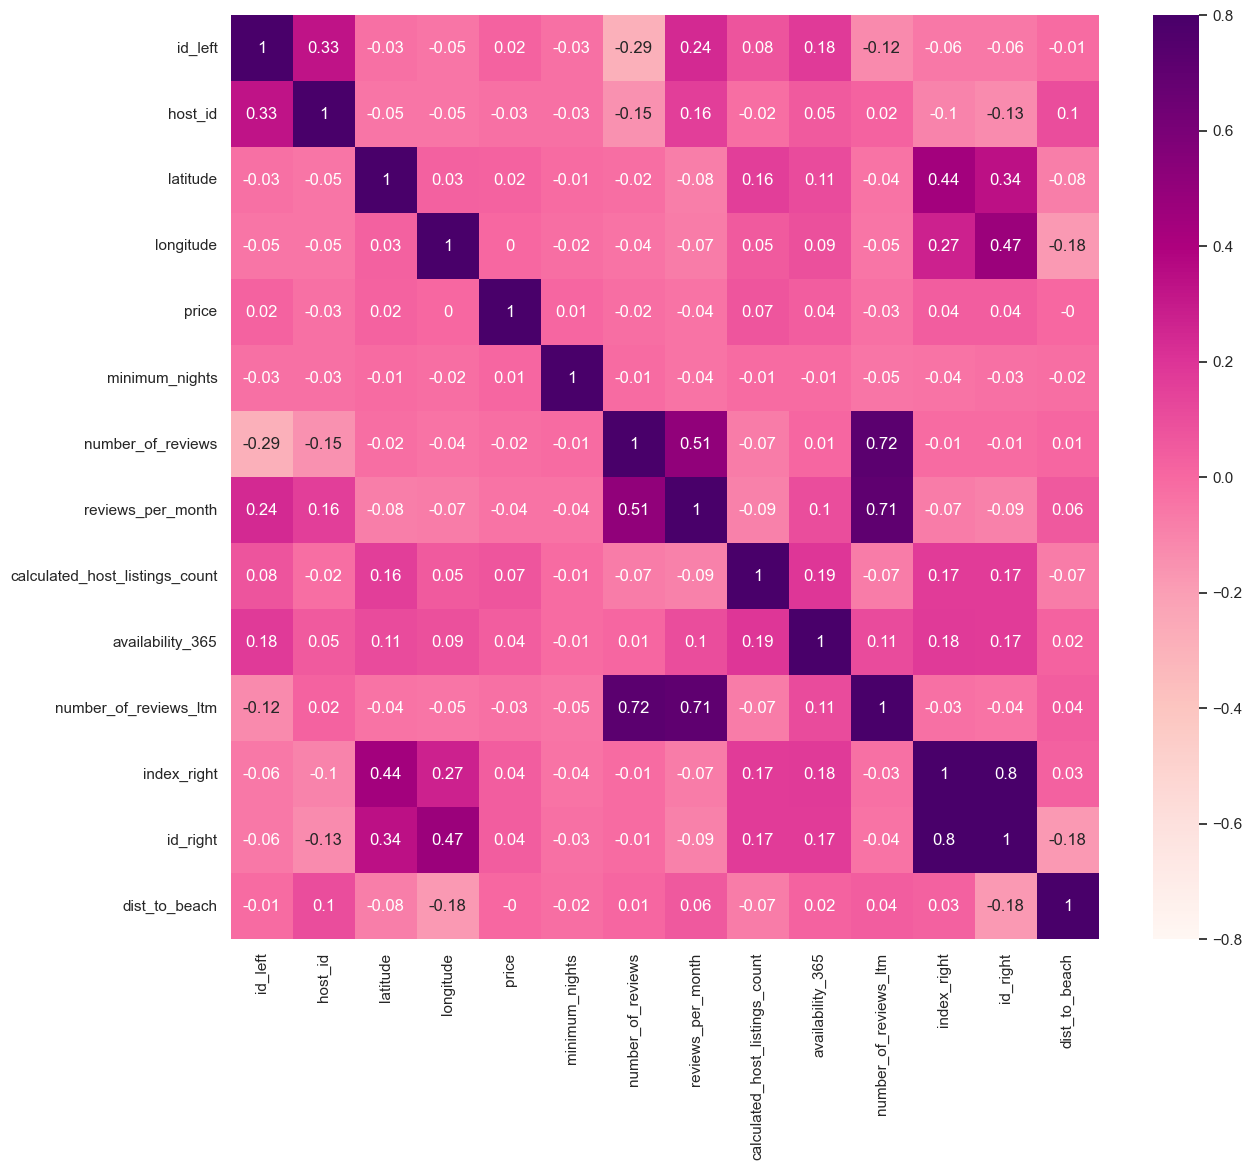

In [33]:
plt.figure(figsize = (14,12))
corr = auck_listings.corr().round(2)
sns.heatmap(corr, annot= True, cmap = 'RdPu', vmin=-.8, vmax=.8) 


#### Spatial Autocorrelation

It actually doesn't look like any of our numerical variables are very correlated with price. There does seem to be some multicollinearity however between the different review categories. We should check to see if  observations show correlation with places located closer to them. 

In [34]:
import libpysal
from libpysal.weights import DistanceBand, util, KNN, attach_islands, spatial_lag
import esda
auck_listings.geometry = auck_listings.geometry.to_crs(epsg = 3857)

# get distance weights for each observation to eachother within 1 km
W = KNN.from_dataframe(auck_listings, k=9, geom_col = 'geometry')

In [35]:
auck_listings.geometry = auck_listings.geometry.to_crs(epsg = 4326)

In [36]:
print(auck_map.geometry.crs)
print(auck_listings.geometry.crs)


EPSG:4326
EPSG:4326


In [37]:
adjlist = W.to_adjlist()
adjlist.head()

focal  neighbor  weight
0      0        47     1.0
1      0        54     1.0
2      0      1338     1.0
3      0      1700     1.0
4      0      2029     1.0

In [38]:
adjlist_price = adjlist.merge(
    auck_listings[['price']],
    how="left",
    left_on="focal",
    right_index=True,
).merge(
    auck_listings[['price']],
    how="left",
    left_on="neighbor",
    right_index=True,
    suffixes=("_focal", "_neighbor"),
)
adjlist_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70812 entries, 0 to 70811
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   focal           70812 non-null  int64  
 1   neighbor        70812 non-null  int64  
 2   weight          70812 non-null  float64
 3   price_focal     70812 non-null  int64  
 4   price_neighbor  70812 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.2 MB


In [39]:
adjlist_price['diff'] = adjlist_price['price_focal'] - adjlist_price['price_neighbor']

In [40]:
all_pairs = np.subtract.outer(auck_listings['price'].values, auck_listings['price'].values)

In [41]:
complement_wr = 1 - W.sparse.toarray()
non_neighboring_diffs = (complement_wr * all_pairs).flatten()

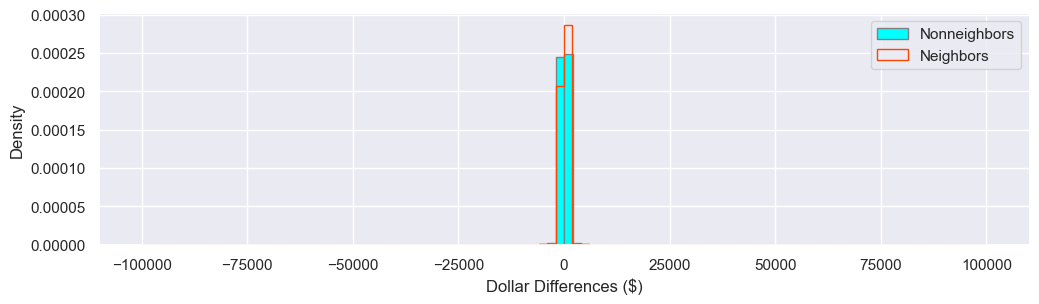

In [42]:
f = plt.figure(figsize=(12, 3))
plt.hist(
    non_neighboring_diffs,
    color="cyan",
    edgecolor="grey",
    density=True,
    bins=100,
    label="Nonneighbors",
)
plt.hist(
    adjlist_price["diff"],
    color="salmon",
    edgecolor="orangered",
    linewidth=1,
    density=True,
    histtype="step",
    bins=100,
    label="Neighbors",
)
sns.despine()
plt.ylabel("Density")
plt.xlabel("Dollar Differences ($)")
plt.legend();

There isn't much difference here. this is most likely because there are factors other than space determing price. We can check the Moran correlation below for each of the different subsets under room type. This plot wont be very informative until we do a log transformation on price since there are significant difference at this point.

In [43]:
types = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']
auck_listings.geometry = auck_listings.geometry.to_crs(epsg = 3857)

for i in range(len(types)):
    
    mask = np.where(auck_listings['room_type'] == types[i])[0]
    masked_data = auck_listings.iloc[mask]
    

    # get distance weights for each observation to eachother within 1 km
    weights = KNN.from_dataframe(masked_data, k = 9, geom_col = 'geometry')
   
    # get islands
    weights_knn = KNN.from_dataframe(masked_data,k=1)
    weights = attach_islands(weights, weights_knn)


    # Calculate Moran's I for filtered data
    moran = esda.Moran(masked_data['price'], weights)
    print(f'Autocorrelation for {types[i]}: {moran.I}')
    print(f'Simmed P_value for {types[i]}: {moran.p_sim}')
    print()
    
auck_listings.room_type.value_counts()

There are no disconnected observations (no islands)!
Autocorrelation for Entire home/apt: 0.0029826466266327867
Simmed P_value for Entire home/apt: 0.085

There are no disconnected observations (no islands)!
Autocorrelation for Private room: 0.00651254438052965
Simmed P_value for Private room: 0.032

There are no disconnected observations (no islands)!
Autocorrelation for Shared room: 0.012315097385768182
Simmed P_value for Shared room: 0.234

There are no disconnected observations (no islands)!
Autocorrelation for Hotel room: 0.21749719291345362
Simmed P_value for Hotel room: 0.001



Entire home/apt    5357
Private room       2389
Hotel room           64
Shared room          58
Name: room_type, dtype: int64

We can see from the p-value above that the is a significance in relationship between a couple distinct categories. Hotels close to each other show a large spatial correlation where house values, most likely due to size, do not. 

As a whole there is a very slight correlation as we could see in the density graph above.

#### Yelp Locations

We can also take a look at the coorelation matrix again to see if there is a correlation between distance any of our landmark or the beach.

In [44]:
top_5_df = gpd.GeoDataFrame(top_5_df, geometry=top_5_df.geometry, crs='EPSG:4326')

In [45]:
%%time
auck_listings.geometry = auck_listings.geometry.to_crs(epsg = 3857)
top_5_df.geometry = top_5_df.geometry.to_crs(epsg = 3857)
col_names = ['rank_1','rank_2','rank_3','rank_4','rank_5']

#initialize columns
for col in col_names:
    auck_listings[col] = None

for i, row in top_5_df.iterrows():
    # location of yelp landmark
    yelp_location = row['geometry']   
    
    # Loop over the cities in the auckland dataframe
    for j, geo_row in auck_listings.iterrows():
        
        # get location of auckland listing
        geo_location = geo_row['geometry']
        #get distance between the two
        distance = yelp_location.distance(geo_location)
        auck_listings.loc[j, col_names[i]] = distance / 1000 #distance into KM's
        
auck_listings[['rank_1','rank_2','rank_3','rank_4','rank_5']] = \
    auck_listings[['rank_1','rank_2','rank_3','rank_4','rank_5']].apply(pd.to_numeric)

CPU times: user 2.45 s, sys: 12.4 ms, total: 2.46 s
Wall time: 2.45 s


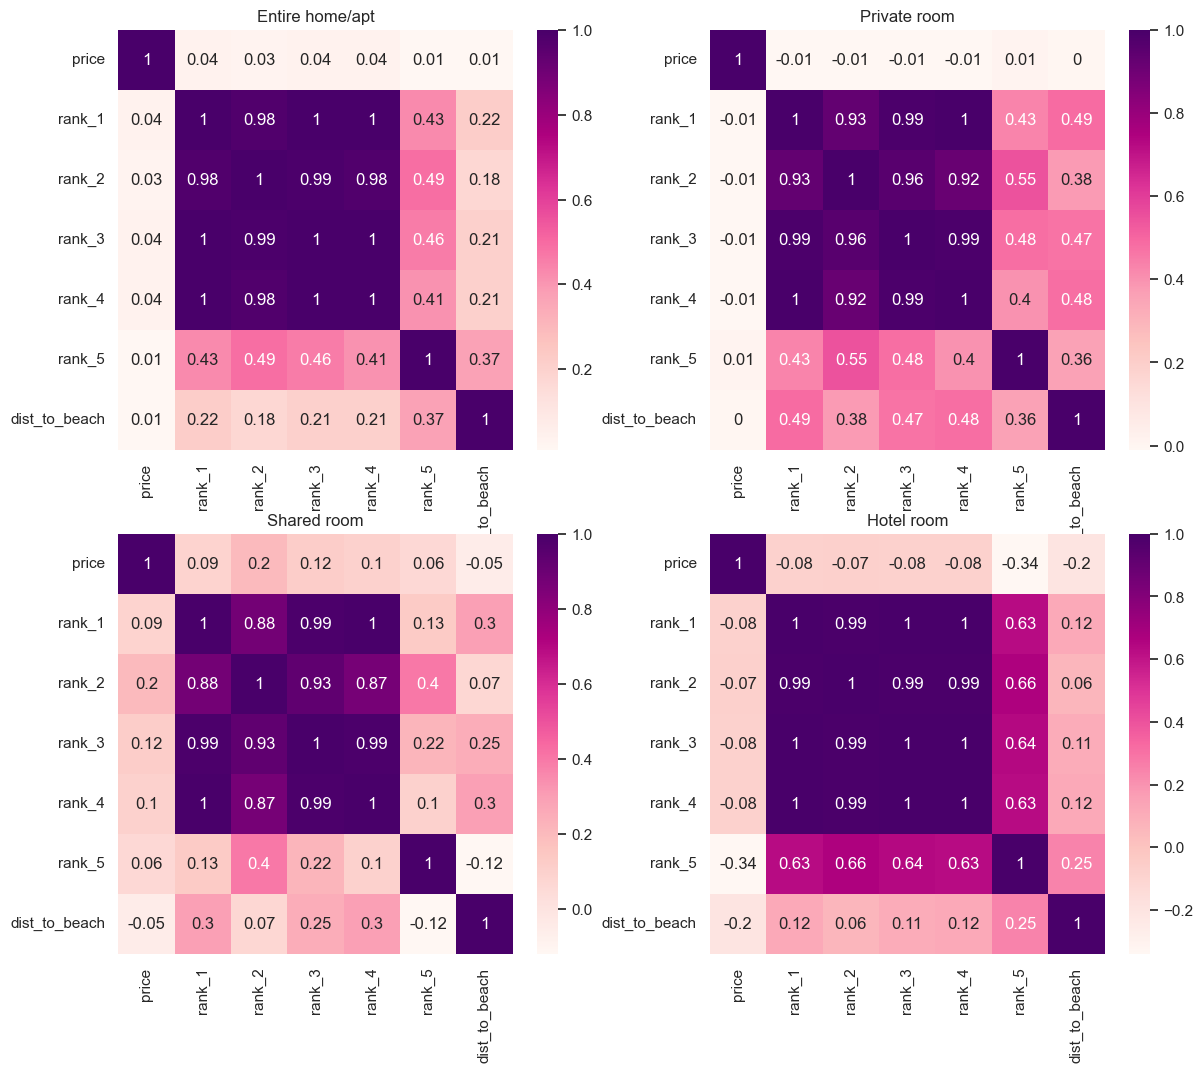

In [46]:
fg, axs = plt.subplots(2, 2, figsize=(14, 12))

for row in range(2):
    for col in range(2):
        i = row * 2 + col  # compute the index for the room type
        mask = np.where(auck_listings['room_type'] == types[i])[0]
        masked_data = auck_listings.iloc[mask]
        corr = masked_data[['price','rank_1','rank_2','rank_3','rank_4','rank_5','dist_to_beach']].corr().round(2)
        sns.heatmap(corr, annot=True, cmap='RdPu', ax=axs[row, col])
        axs[row, col].set_title(f'{types[i]}')

Instead of using each different column it might be better to create just one feature with the assumption that the closer you are located to any of the features (minimum distance) the greater the price might be. Since being neart the beach isn't a concern if we are looking in the cit center.

In [47]:
auck_listings['min_dist'] = auck_listings[['price', 'rank_1', 'rank_2', 'rank_3', 'rank_4', 'rank_5']].min(axis=1)


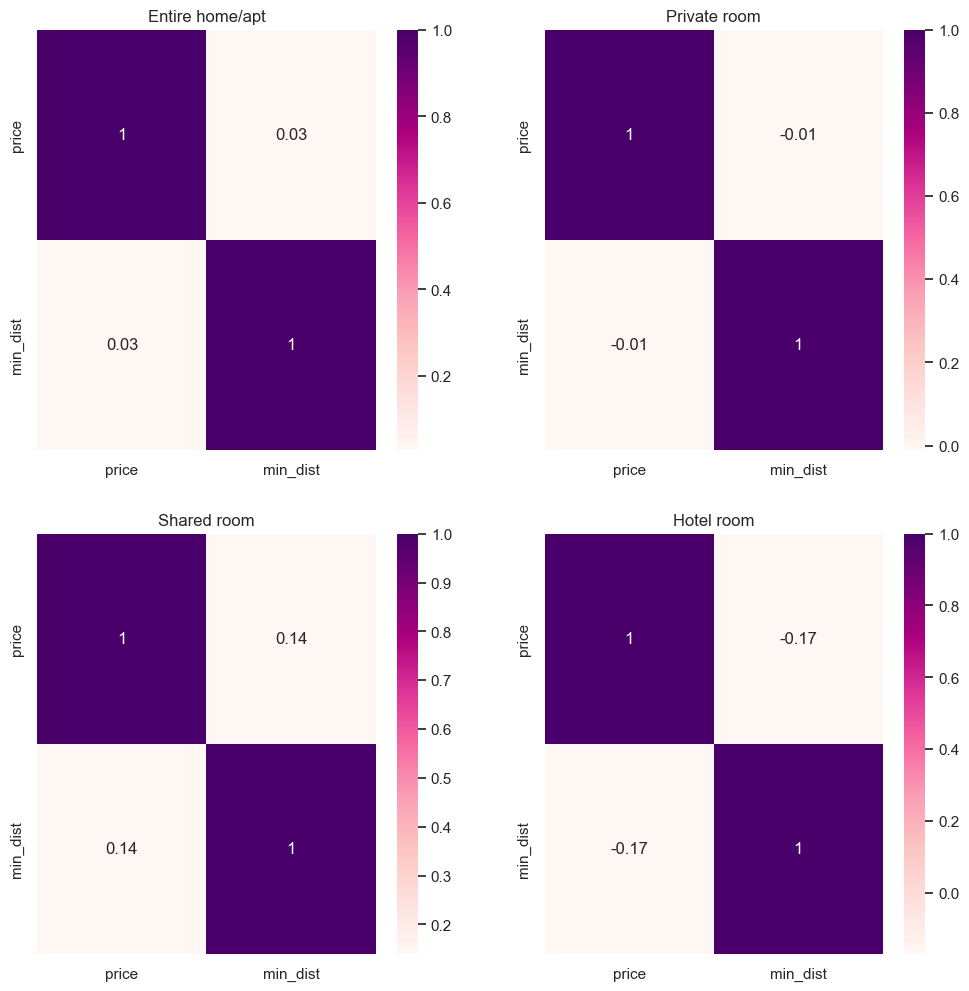

In [48]:
fg, axs = plt.subplots(2, 2, figsize=(12, 12))

for row in range(2):
    for col in range(2):
        i = row * 2 + col  # compute the index for the room type
        mask = np.where(auck_listings['room_type'] == types[i])[0]
        masked_data = auck_listings.iloc[mask]
        corr = masked_data[['price', 'min_dist']].corr().round(2)
        sns.heatmap(corr, annot=True, cmap='RdPu', ax=axs[row, col])
        axs[row, col].set_title(f'{types[i]}')

Again not very distinct but I suspect there may be an interaction effect based on the neighborhood. 

#### Restaurants, Bars, and Cafe's

There is one more feature I would like to explore before we start modeling the regression problem. Another important feature might be the amount of restaurants and bar within the proximity of the listing. Using a 500 meter buffer window would make the amenities within an easy walking distance.

In [49]:
import osmnx as osm 
auck_listings.geometry = auck_listings.geometry.to_crs(epsg=4326)

#get bounding box
bb = auck_listings.unary_union.convex_hull

#get amenities with a bounding box
amenities = osm.geometries_from_polygon(bb, tags={'amenity': ['restaurant', 'bar', 'cafe']})
amenities.head()
amenities = amenities.reset_index()[['element_type', 'amenity', 'osmid', 'name', 'geometry']]

type(amenities)


geopandas.geodataframe.GeoDataFrame

In [50]:
auck_listings.geometry = auck_listings.geometry.to_crs(epsg=3857)
#create a buffer aound each airbnb lisiting
auck_listings['buffer'] = auck_listings.buffer(500)


In [51]:
# Change all coordinate systems at the same time
def change_crs(x):
    auck_listings.geometry = auck_listings.geometry.to_crs(epsg = x)
    top_5_df.geometry = top_5_df.geometry.to_crs(epsg = x)
    auck_map.geometry = auck_map.geometry.to_crs(epsg = x)
    amenities.geometry = amenities.geometry.to_crs(epsg = x)

In [52]:
med_price = auck_listings.groupby('suburb')['price'].median().to_frame('med_price')

auck_map = pd.merge(auck_map,med_price, left_on='suburb', right_index=True, how='left')
med_price.head(1)

med_price
suburb             
Auckland      150.0

/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_57593/2983282503.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


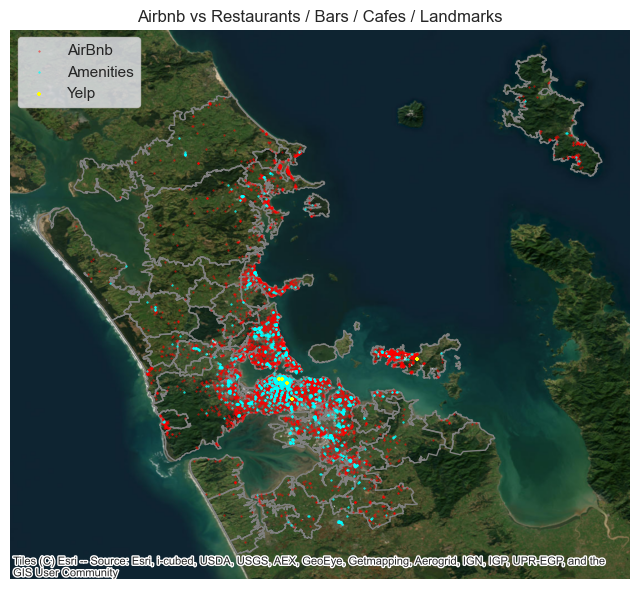

In [53]:
change_crs(4326)
f, ax = plt.subplots(1,figsize = (8,8))
ax = auck_map.plot(ax = ax, color = 'None',edgecolor = 'grey')
auck_listings.plot(ax = ax, marker = '.', color = 'red', alpha = .7, label = 'AirBnb', markersize = .7)
amenities.plot(ax = ax, color = 'cyan', marker = '*', alpha = .7, label = 'Amenities',markersize = .5)
top_5_df.plot(ax = ax, color = 'yellow', marker = '+',  alpha = 1, label = 'Yelp', markersize = 10)
plt.title('Airbnb vs Restaurants / Bars / Cafes / Landmarks')

#add legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels)

# add background
contextily.add_basemap(ax=ax, crs=auck_listings.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('airbnb_listings_with amenities.png', dpi=300, bbox_inches='tight')

In [54]:
med_price.sort_values('med_price',ascending=False).head(20)

med_price
suburb                                        
Kawau Island                             799.0
Muriwai                                  430.0
Omaha                                    425.0
Waiheke Island                           390.0
Waiuku                                   350.0
Matakana                                 300.0
Snells Beach                             293.5
Piha                                     292.5
Whangateau                               290.0
Great Barrier Island (Aotea Island)      285.0
Leigh                                    251.0
Point Wells                              250.0
Taupaki                                  250.0
Clevedon                                 250.0
Waitoki                                  229.5
Wellsford                                225.0
Wainui                                   225.0
Te Henga (Bethells Beach)                224.5
Āwhitu                                   212.0
Tapora                                   204.0

/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_57593/3156972197.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm, shrink=0.5)


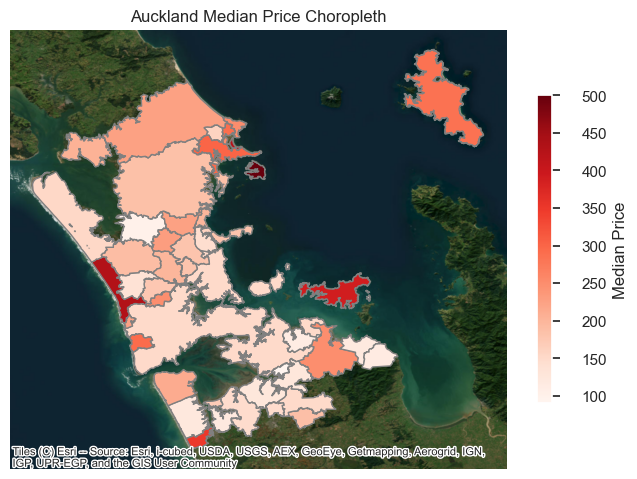

In [55]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

change_crs(4326)
f, ax = plt.subplots(1,figsize = (8,8))

# add graphs
ax = auck_map.plot(ax = ax, column = 'med_price', cmap = 'Reds',edgecolor = 'grey', vmax = 500)

# add colorbar
# Define the colorbar mappable and norm
norm = Normalize(vmin=auck_map['med_price'].min(), vmax=500)
sm = ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])

# Add the colorbar
cb = plt.colorbar(sm, shrink=0.5)
cb.set_label('Median Price')
cb.ax.yaxis.set_tick_params(pad=15)

# title
plt.title('Auckland Median Price Choropleth')


# add background
contextily.add_basemap(ax=ax, crs=auck_listings.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('median_airbnb_listings.png', dpi=300, bbox_inches='tight')

In [56]:
auck_listings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7868 entries, 0 to 7867
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id_left                         7868 non-null   int64   
 1   host_id                         7868 non-null   int64   
 2   neighbourhood_group             7868 non-null   object  
 3   neighbourhood                   7868 non-null   object  
 4   latitude                        7868 non-null   float64 
 5   longitude                       7868 non-null   float64 
 6   room_type                       7868 non-null   object  
 7   price                           7868 non-null   int64   
 8   minimum_nights                  7868 non-null   int64   
 9   number_of_reviews               7868 non-null   int64   
 10  reviews_per_month               7868 non-null   float64 
 11  calculated_host_listings_count  7868 non-null   int64   
 12  availability

In [57]:
change_crs(3857)

joined_buffer = gpd.sjoin(amenities,auck_listings.set_geometry('buffer')[['id_left','buffer', 'suburb']],  predicate='within')
joined_buffer.shape

(105542, 8)

In [58]:
# getting total amenities by neighbourhood 
neighb_count = joined_buffer.groupby('suburb')['osmid'].count().sort_values().to_frame('nbor_count')

In [59]:
# Showing the count of amenities within each buffer
point_count = joined_buffer.groupby(['id_left'])['osmid'].count().sort_values(ascending=False).to_frame('amen_count')
point_count.head()

amen_count
id_left                       
50381085                   167
38882100                   164
683597667417296811         163
603103217294703283         163
30317976                   162

In [60]:
# merge the groupby and normailze count buffer count by the number of listings in the neighbourhood
auck_listings = pd.merge(auck_listings, point_count,how='left', left_on='id_left', right_index=True)
auck_listings = pd.merge(auck_listings, neighb_count, how='left', left_on='suburb', right_index=True)
auck_listings[['nbor_count']] = auck_listings[['nbor_count']].fillna(1)

# normalize
auck_listings.amen_count = auck_listings.amen_count.fillna(0)
auck_listings['amenities_norm'] = auck_listings.amen_count.div(auck_listings.nbor_count)
auck_listings.head(2)

id_left  host_id neighbourhood_group     neighbourhood  latitude  \
0    52133   240890            Auckland       Howick Ward -36.91515   
1    86839   475889            Auckland  North Shore Ward -36.78811   

   longitude     room_type  price  minimum_nights  number_of_reviews  ...  \
0  174.93825  Private room    119               1                  0  ...   
1  174.68541  Private room     52               2                  0  ...   

      rank_1     rank_2     rank_3     rank_4     rank_5   min_dist  \
0  21.697139  16.933993  19.776298  22.441336  23.820717  16.933993   
1  11.959581  19.036810  14.036390  11.386529  45.740561  11.386529   

                                              buffer  amen_count nbor_count  \
0  POLYGON ((19474536.910 -4427286.381, 19474534....         0.0   103974.0   
1  POLYGON ((19446390.890 -4409613.064, 19446388....         0.0   103974.0   

   amenities_norm  
0             0.0  
1             0.0  

[2 rows x 30 columns]

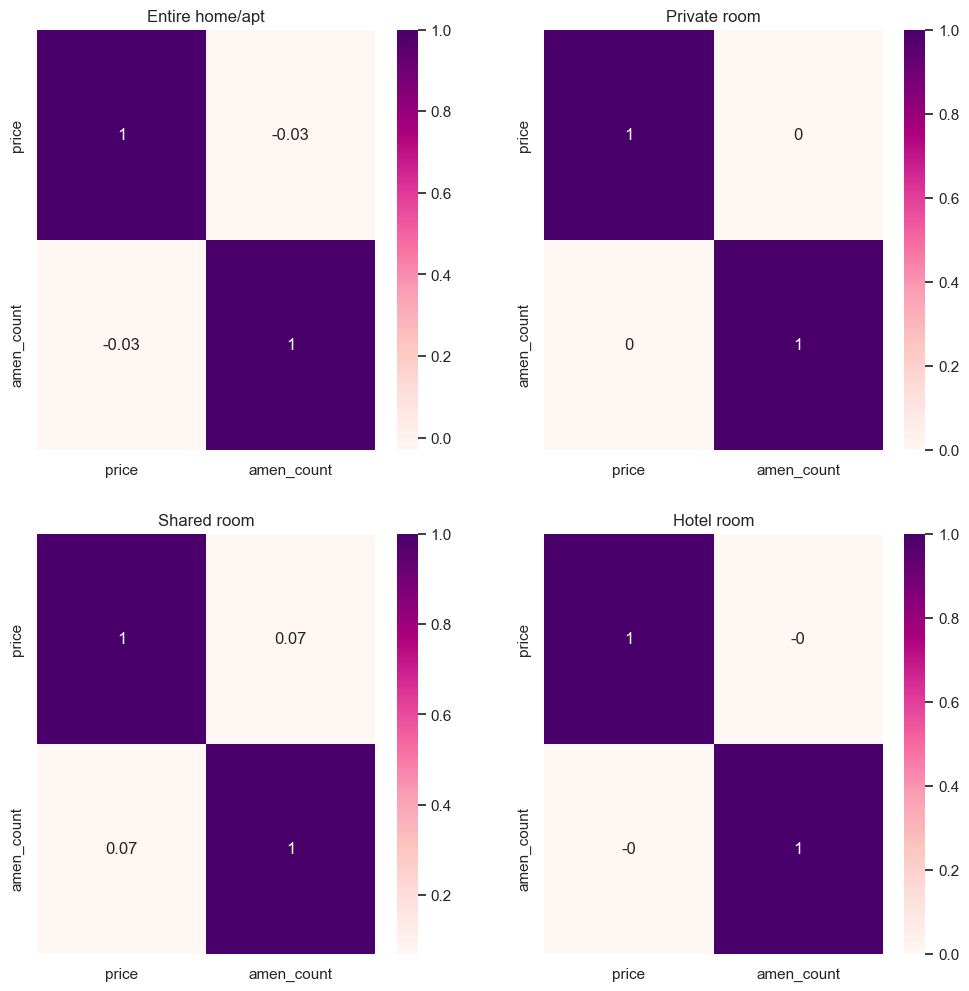

In [61]:
fg, axs = plt.subplots(2, 2, figsize=(12, 12))

for row in range(2):
    for col in range(2):
        i = row * 2 + col  # compute the index for the room type
        mask = np.where(auck_listings['room_type'] == types[i])[0]
        masked_data = auck_listings.iloc[mask]
        corr = masked_data[['price', 'amen_count']].corr().round(2)
        sns.heatmap(corr, annot=True, cmap='RdPu', ax=axs[row, col])
        axs[row, col].set_title(f'{types[i]}')

#### Outliers

Lets take another look at outliers before we start modeling. We have already converted price logarythmically. We likely have to do that with other variable to get more of a normal distribution for our variables.

In [62]:
q_05,q_95 = np.percentile(auck_listings.price, [20,80])
limit = (q_95 - q_05) * 2
limit

562.0

In [63]:
auck_listings = auck_listings[auck_listings['price']<limit]

Which suburbs have the highest median value?

Text(0.5, 1.03, 'Top 20 Listings by Mean Price')

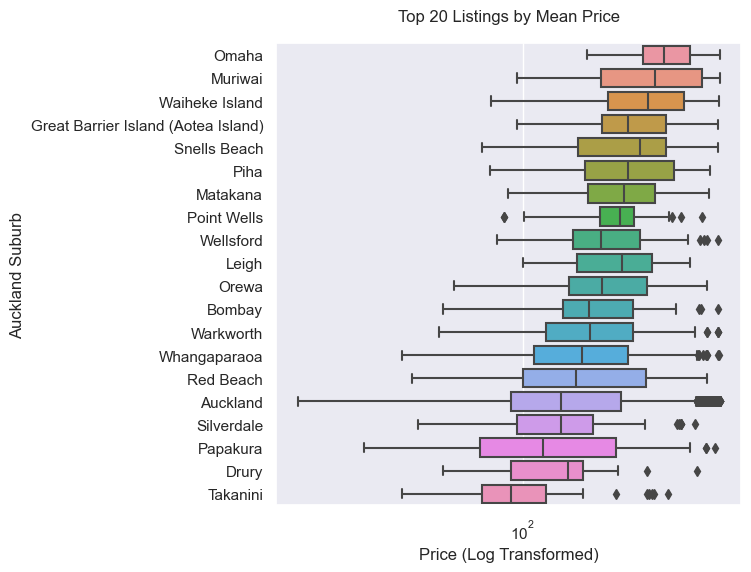

In [64]:
# order suburbs
suburb_counts = auck_listings['suburb'].value_counts()
ordered_suburbs = suburb_counts.index.tolist()
ordered_suburbs = ordered_suburbs[:20]

suburb_median = auck_listings[auck_listings['suburb'].isin(ordered_suburbs)].groupby('suburb')['price']\
                .mean().sort_values(ascending = False)
ordered_suburbs = suburb_median.index.tolist()

plt.figure(figsize=(6, 6))
sns.boxplot(data = auck_listings, x = 'price', y='suburb', order=ordered_suburbs)
plt.xlabel('Price (Log Transformed)')
plt.ylabel('Auckland Suburb')
plt.xscale('log')
plt.title('Top 20 Listings by Mean Price',y=1.03)

Auckland Central seems to have the widest array of prices which isn't surprising. However, some of these listings are extreme outliers. For this analysis we will remove any house price that is twice an customized range of the 95% quantile and the 5% quantile. This will remove 110 values from our dataframe.

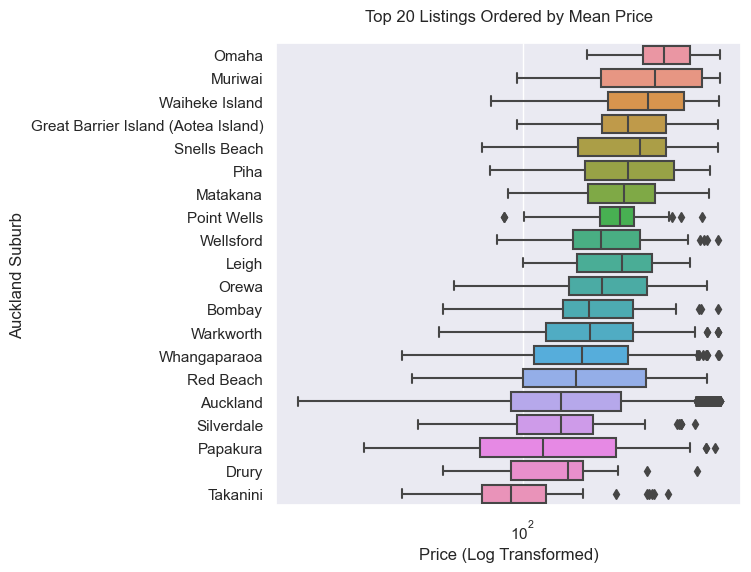

In [65]:
# order suburbs
suburb_counts = auck_listings['suburb'].value_counts()
ordered_suburbs = suburb_counts.index.tolist()
ordered_suburbs = ordered_suburbs[:20]

suburb_median = auck_listings[auck_listings['suburb'].isin(ordered_suburbs)].groupby('suburb')['price']\
                .mean().sort_values(ascending = False)
ordered_suburbs = suburb_median.index.tolist()

plt.figure(figsize=(6, 6))
sns.boxplot(data = auck_listings, x = 'price', y='suburb', order=ordered_suburbs)
plt.xlabel('Price (Log Transformed)')
plt.ylabel('Auckland Suburb')
plt.xscale('log')
plt.title('Top 20 Listings Ordered by Mean Price',y=1.03)
plt.savefig('median_airbnb_listings_boxplot.png', dpi=300, bbox_inches='tight')

In [66]:
auck_listings = auck_listings[auck_listings['minimum_nights']<30]

In [67]:
auck_listings['number_of_reviews_log'] = np.log(auck_listings[['number_of_reviews']])

/Users/laffer/Desktop/IoD/iod_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Text(0.5, 1.03, 'Numeric Variables Distribution by Room Type')

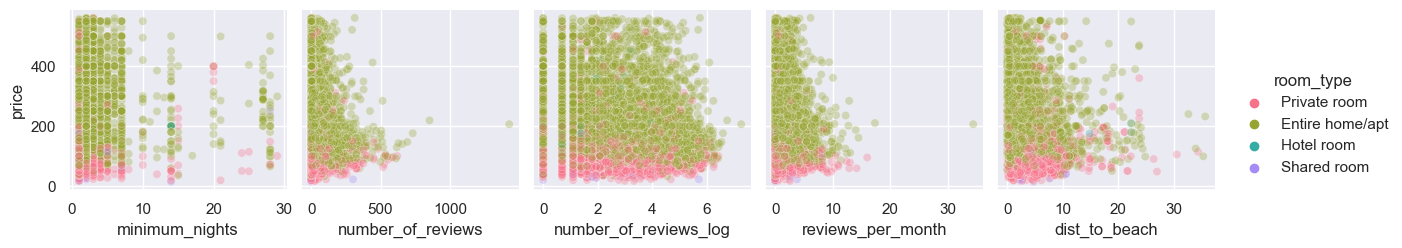

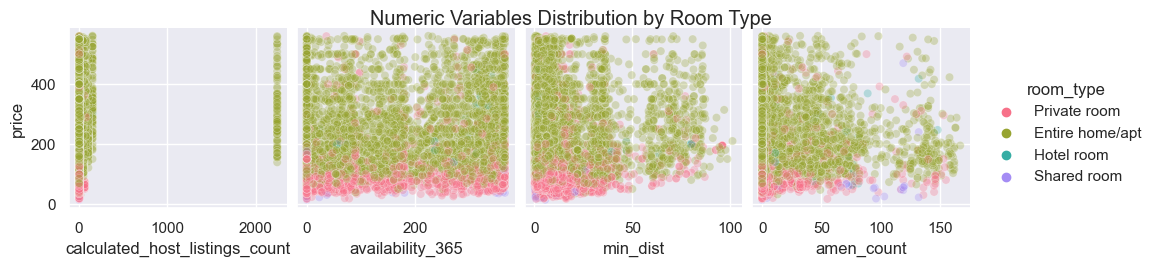

In [68]:
cats1 = ['minimum_nights', 'number_of_reviews', 'number_of_reviews_log','reviews_per_month', 'dist_to_beach']
cats2 = ['calculated_host_listings_count', 'availability_365', 'min_dist', 'amen_count']

sns.pairplot(data=auck_listings, x_vars=cats1, y_vars='price', hue='room_type', palette='husl', plot_kws={'alpha':.3})
sns.pairplot(data=auck_listings, x_vars=cats2, y_vars='price', hue='room_type', palette='husl', plot_kws={'alpha':.3})
plt.suptitle('Numeric Variables Distribution by Room Type', y=1.03)


In [69]:
auck_listings.describe()

id_left       host_id     latitude    longitude        price  \
count  6.998000e+03  6.998000e+03  6998.000000  6998.000000  6998.000000   
mean   2.442155e+17  1.569409e+08   -36.817495   174.786721   195.852243   
std    3.473483e+17  1.429927e+08     0.156053     0.140141   124.919286   
min    5.213300e+04  4.282200e+04   -37.250050   174.255950    14.000000   
25%    2.340344e+07  4.064349e+07   -36.889230   174.724825    99.000000   
50%    4.252207e+07  1.107382e+08   -36.850225   174.761800   160.000000   
75%    6.697854e+17  2.409388e+08   -36.788533   174.826407   268.000000   
max    8.429197e+17  5.042531e+08   -36.117700   175.509280   561.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count     6998.000000        6998.000000        6998.000000   
mean         2.399543          40.031295           1.484673   
std          3.080476          72.876525           1.856970   
min          1.000000           0.000000           0.000000   
25%          1.000000           2.000000           0.170000   
50%          2.000000          12.000000           0.870000   
75%          2.000000          45.000000           2.140000   
max         29.000000        1427.000000          34.410000   

       calculated_host_listings_count  availability_365  ...       rank_1  \
count                     6998.000000       6998.000000  ...  6998.000000   
mean                        43.759646        153.830094  ...    18.348062   
std                        275.297930        134.916015  ...    20.038871   
min                          1.000000          0.000000  ...     0.039870   
25%                          1.000000         13.000000  ...     3.848912   
50%                          1.000000        131.000000  ...    11.827282   
75%                          4.000000        298.000000  ...    28.801666   
max                       2244.000000        365.000000  ...   124.987394   

            rank_2       rank_3       rank_4       rank_5     min_dist  \
count  6998.000000  6998.000000  6998.000000  6998.000000  6998.000000   
mean     20.618595    18.584493    18.457039    40.636255    14.442759   
std      20.293186    20.056639    20.066784    15.919620    18.221881   
min       0.478597     0.601105     0.036541     0.483913     0.036541   
25%       7.334770     4.140004     3.680206    36.014482     2.149321   
50%      13.658349    12.439045    11.890294    38.886088     8.046068   
75%      28.588098    28.093050    29.249074    45.539542    17.397920   
max     129.052870   125.393672   125.468832   104.231591   101.093705   

        amen_count     nbor_count  amenities_norm  number_of_reviews_log  
count  6998.000000    6998.000000     6998.000000            6998.000000  
mean     13.865819   77260.455702        0.003024                   -inf  
std      29.895624   45348.373202        0.029781                    NaN  
min       0.000000       1.000000        0.000000                   -inf  
25%       0.000000     902.000000        0.000000               0.693147  
50%       1.000000  103974.000000        0.000010               2.484907  
75%      10.000000  103974.000000        0.000183               3.806662  
max     167.000000  103974.000000        1.000000               7.263330  

[8 rows x 24 columns]

20
83.2525643670164


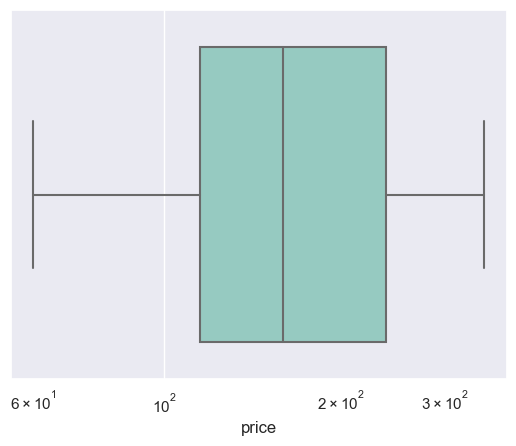

In [70]:
suburb_counts = auck_listings['suburb'].value_counts()
subs = suburb_counts[suburb_counts < 6].index.tolist()

sub_list = auck_listings[auck_listings['suburb'].isin(subs)]
print(sub_list.price.count())
print(sub_list.price.std())
sns.boxplot(sub_list, x = 'price')
plt.xscale('log')

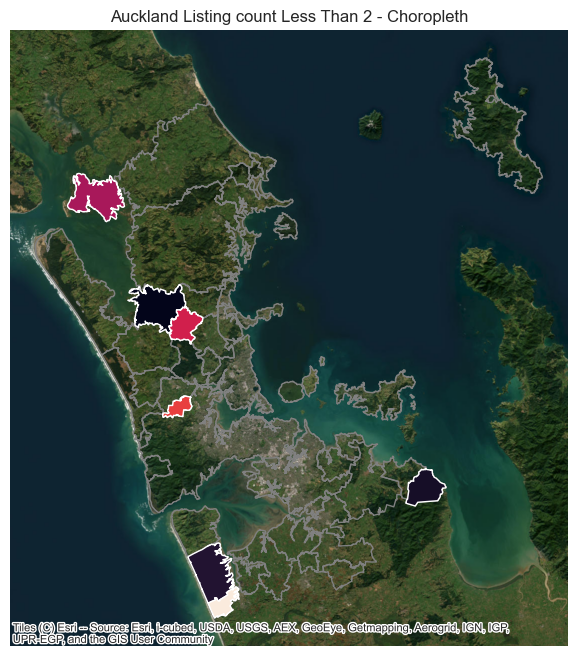

In [71]:
sub_median = sub_list.groupby('suburb')['price'].median().to_frame('sub_median')
sub_map = pd.merge(auck_map,sub_median, left_on='suburb', right_index=True)

fg, ax = plt.subplots(1, figsize=(8,8))

ax = auck_map.plot(ax = ax, color = 'None', edgecolor= 'grey')
sub_map.plot(ax = ax, column='sub_median')
# title
plt.title('Auckland Listing count Less Than 2 - Choropleth')

# add background
contextily.add_basemap(ax=ax, crs=auck_listings.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('.png', dpi=300, bbox_inches='tight')

In [72]:
auck_listings['suburb'] = np.where(auck_listings['suburb'].isin(subs), 'Other', auck_listings['suburb'])

In [73]:
auck_listings.dist_to_beach.describe()
auck_listings['is_coastal'] = np.where(auck_listings['dist_to_beach']<.2, 1, 0)

In [74]:
auck_listings.suburb.nunique()

40

We can also add a feature for whether the the suburb is located in a coastal suburb.

In [75]:
coastal_suburb = list(auck_listings[auck_listings['is_coastal']==1]['suburb'].unique())

auck_listings['coastal_suburb'] = np.where(auck_listings['suburb'].isin(coastal_suburb), 1, 0)

Now that we have done a significant amount of feature engineering we can start putting together a couple of models. Since we are predicting price the price of a listing in our dataset we will be using regression models. It is important to note that price is already logrythmically tranformed already. The core idea of linear regression is to explain the variation in a given (dependent) variable as a linear function of a collection of other (explanatory) variables.

First thing we will do is get rid of some of our multicollinearity and stick with our calculated statistics.

In [76]:

X = auck_listings[['room_type', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month','calculated_host_listings_count',
                   'availability_365','min_dist','amen_count', 'dist_to_beach', 'is_coastal']]
y = np.log(auck_listings[['price']])

y = np.ravel(y)

Having 308 different suburbs that need to be one hot encoded can be a problem. Here there are three options;
1. Run the models as is and they will take a really long time especially with a GridSearch for the best parameters.
2. Severly limit the search parameters in the GridSearch
3. Dimensionality Reduction: This is the optimal option. The problem here is the algorithm becomes a black box.

We will run the simple linear regression first without any additional parameters search and see what our coefficients look like.

In [77]:
# preset my categorical and numerical features
cat_features = ['is_coastal', 'room_type',]
num_features = ['minimum_nights','number_of_reviews', 'reviews_per_month','calculated_host_listings_count',
                'availability_365','min_dist','amen_count', 'dist_to_beach']
interactions = ['amen_count', 'min_dist', 'dist_to_beach']


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import spreg
from pprint import pprint

/Users/laffer/Desktop/IoD/iod_env/lib/python3.11/site-packages/spreg/user_output.py:14: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


#### Preprocessor

In [79]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=123)

cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
interaction_transformer = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True))])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features),
    ('poly', interaction_transformer, interactions),
    ('num', num_transformer, num_features)
    ])
preprocessor.fit(X_train).output_indices_

{'cat': slice(0, 4, None),
 'poly': slice(4, 11, None),
 'num': slice(11, 19, None),
 'remainder': slice(0, 0, None)}

#### Simple Linear Regression Without GridSearch


In [80]:
%%time
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear_cv', LinearRegression(n_jobs=6))])

scores = cross_val_score(linear_pipeline, X_train, y_train, cv=10, scoring='r2')

# Print the mean R-squared score and standard deviation
print(f"Max R-squared score: {scores.max():.2f}")
print(f"Standard deviation: {scores.std():.2f}")


Max R-squared score: 0.48
Standard deviation: 0.03
CPU times: user 1.84 s, sys: 2.57 s, total: 4.41 s
Wall time: 589 ms


In [81]:
%%time
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression())])


linear_grid = {'preprocessor__transformer_weights': [{'num': 0.25, 'cat': 1.0},
                                                    {'num': 0.5, 'cat': 1.0},
                                                    {'num': 1, 'cat': 1}],
              'Linear__fit_intercept': [True,False]}

linear_search = GridSearchCV(linear_pipeline, linear_grid, cv=10, scoring='r2', n_jobs=6,)

linear_search.fit(X_train, y_train)

#--------------------------------------------------------------------------------------------------------

best_estimator = linear_search.best_estimator_

# Get the feature names after preprocessing
ohe = best_estimator.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = num_features + list(ohe.get_feature_names_out(cat_features))

# Get the coefficients and combine with feature names
coefficients = best_estimator.named_steps['Linear'].coef_
coef_names = list(zip(feature_names, coefficients))


n = X_train.shape[0]  # number of observations
k = len(best_estimator.named_steps['preprocessor'].transformers_) - 1  # number of independent variables
r2 = linear_search.best_score_  # R-squared score
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

#--------------------------------------------------------------------------------------------------------

print("Linear best params: " + str(linear_search.best_params_))
print()
print("Linear Adjusted R Squared: " + str(adjusted_r2))
print()
for coef_name in coef_names:
    print(f"{coef_name[0]}: {coef_name[1].round(2)}")
    
lin_coef_df = pd.DataFrame(coef_names, columns=['Linear feature', 'Linear coefficient'])


lin_coef_df = lin_coef_df.sort_values(by='Linear coefficient', ascending=False)

# Display the coefficients
lin_coef_df.head(10)

Linear best params: {'Linear__fit_intercept': True, 'preprocessor__transformer_weights': {'num': 1, 'cat': 1}}

Linear Adjusted R Squared: 0.4325293761862117

minimum_nights: 0.15
number_of_reviews: -0.26
reviews_per_month: -0.83
calculated_host_listings_count: -1.33
availability_365: 0.0
min_dist: 0.0
amen_count: 0.0
dist_to_beach: -0.03
is_coastal_1: 0.0
room_type_Hotel room: -0.0
room_type_Private room: 0.0
room_type_Shared room: 0.0
CPU times: user 112 ms, sys: 125 ms, total: 238 ms
Wall time: 1.2 s


Linear feature  Linear coefficient
0           minimum_nights        1.524945e-01
11   room_type_Shared room        2.438857e-03
5                 min_dist        1.969101e-03
10  room_type_Private room        3.590071e-04
6               amen_count        2.676596e-04
8             is_coastal_1        2.161748e-04
4         availability_365        4.822531e-16
9     room_type_Hotel room       -7.500342e-04
7            dist_to_beach       -2.521248e-02
1        number_of_reviews       -2.647036e-01

#### Lasso Regression

In [82]:
%%time

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso(max_iter=10000, random_state=123))])

lasso_pipeline.get_params().keys()


lasso_grid = {'preprocessor__transformer_weights': [{'num': 0.5, 'cat': 1.0},
                                                    {'num': 1, 'cat': 1}],
            'Lasso__alpha': [.0001,.005, .001],
              'Lasso__fit_intercept': [True,False]}

lasso_search = GridSearchCV(lasso_pipeline, lasso_grid, cv=5, scoring='r2',n_jobs=6)

lasso_search.fit(X_train, y_train)
#--------------------------------------------------------------------------------------------------------

best_estimator = lasso_search.best_estimator_

# Get the feature names after preprocessing
ohe = best_estimator.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = num_features + list(ohe.get_feature_names_out(cat_features))

# Get the coefficients and combine with feature names
coefficients = best_estimator.named_steps['Lasso'].coef_
coef_names = list(zip(feature_names, coefficients))

#--------------------------------------------------------------------------------------------------------

n = X_train.shape[0]  # number of observations
k = len(best_estimator.named_steps['preprocessor'].transformers_) - 1  # number of independent variables
r2 = lasso_search.best_score_  # R-squared score
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("Lasso best params: " + str(lasso_search.best_params_))
print()
print("Lasso Adjusted R2: " + str(adjusted_r2))
print()
for coef_name in coef_names:
    print(f"{coef_name[0]}: {coef_name[1].round(2)}")
    
lasso_coef_df = pd.DataFrame(coef_names, columns=['Lasso feature', 'Lasso coefficient'])


lasso_coef_df = lasso_coef_df.sort_values(by='Lasso coefficient', ascending=False)

# Display the coefficients
lasso_coef_df.head(10)

Lasso best params: {'Lasso__alpha': 0.0001, 'Lasso__fit_intercept': False, 'preprocessor__transformer_weights': {'num': 0.5, 'cat': 1.0}}

Lasso Adjusted R2: 0.4326462744762335

minimum_nights: 0.15
number_of_reviews: -0.25
reviews_per_month: -0.83
calculated_host_listings_count: -1.32
availability_365: 5.4
min_dist: 0.0
amen_count: 0.0
dist_to_beach: -0.03
is_coastal_1: 0.0
room_type_Hotel room: -0.0
room_type_Private room: 0.0
room_type_Shared room: 0.0
CPU times: user 2.77 s, sys: 207 ms, total: 2.97 s
Wall time: 1.41 s


Lasso feature  Lasso coefficient
4         availability_365           5.402279
0           minimum_nights           0.150132
11   room_type_Shared room           0.004745
5                 min_dist           0.001995
10  room_type_Private room           0.000358
6               amen_count           0.000287
8             is_coastal_1           0.000218
9     room_type_Hotel room          -0.000762
7            dist_to_beach          -0.027302
1        number_of_reviews          -0.249734

#### Ridge Regression

In [83]:
%%time
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(max_iter=10000, random_state=123))])

ridge_grid = {'preprocessor__transformer_weights': [{'num': 0.5, 'cat': 1.0},
                                                    {'num': 1, 'cat': 1}],
              'Ridge__alpha': [0.01, 0.1, 1.0, 10, 50],
             'Ridge__fit_intercept': [True,False]}

ridge_search = GridSearchCV(ridge_pipeline, ridge_grid, cv=5, scoring='r2', n_jobs=6)

ridge_search.fit(X_train, y_train)

#--------------------------------------------------------------------------------------------------------

best_estimator = ridge_search.best_estimator_

# Get the feature names after preprocessing
ohe = best_estimator.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = num_features + list(ohe.get_feature_names_out(cat_features))

# Get the coefficients and combine with feature names
coefficients = best_estimator.named_steps['Ridge'].coef_ 
coef_names = list(zip(feature_names, coefficients))


n = X_train.shape[0]  # number of observations
k = len(best_estimator.named_steps['preprocessor'].transformers_) - 1  # number of independent variables
r2 = ridge_search.best_score_  # R-squared score
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

#--------------------------------------------------------------------------------------------------------

print("Ridge best params: " + str(ridge_search.best_params_))
print()
print("Ridge Adjusted R Squared: " + str(adjusted_r2))
print()
for coef_name in coef_names:
    print(f"{coef_name[0]}: {coef_name[1].round(2)}")
    
ridge_coef_df = pd.DataFrame(coef_names, columns=['Ridge feature', 'Ridge coefficient'])


ridge_coef_df = ridge_coef_df.sort_values(by='Ridge coefficient', ascending=False)

# Display the coefficients
ridge_coef_df.head(10)

Ridge best params: {'Ridge__alpha': 0.1, 'Ridge__fit_intercept': False, 'preprocessor__transformer_weights': {'num': 0.5, 'cat': 1.0}}

Ridge Adjusted R Squared: 0.43264271958970435

minimum_nights: 0.15
number_of_reviews: -0.26
reviews_per_month: -0.83
calculated_host_listings_count: -1.33
availability_365: 3.83
min_dist: 0.02
amen_count: 0.04
dist_to_beach: 0.22
is_coastal_1: 0.0
room_type_Hotel room: -0.0
room_type_Private room: 0.0
room_type_Shared room: 0.0
CPU times: user 859 ms, sys: 252 ms, total: 1.11 s
Wall time: 353 ms


Ridge feature  Ridge coefficient
4         availability_365           3.827932
7            dist_to_beach           0.218661
0           minimum_nights           0.152588
6               amen_count           0.041805
5                 min_dist           0.016928
11   room_type_Shared room           0.004942
10  room_type_Private room           0.000358
8             is_coastal_1           0.000217
9     room_type_Hotel room          -0.000753
1        number_of_reviews          -0.263866

In [84]:
feat_coefs_df = pd.merge(ridge_coef_df, lasso_coef_df, left_on='Ridge feature' ,right_on='Lasso feature')
feat_coefs_df = pd.merge(feat_coefs_df, lin_coef_df, left_on='Ridge feature' ,right_on='Linear feature')
feat_coefs_df.round(2)

Ridge feature  Ridge coefficient  \
0                 availability_365               3.83   
1                    dist_to_beach               0.22   
2                   minimum_nights               0.15   
3                       amen_count               0.04   
4                         min_dist               0.02   
5            room_type_Shared room               0.00   
6           room_type_Private room               0.00   
7                     is_coastal_1               0.00   
8             room_type_Hotel room              -0.00   
9                number_of_reviews              -0.26   
10               reviews_per_month              -0.83   
11  calculated_host_listings_count              -1.33   

                     Lasso feature  Lasso coefficient  \
0                 availability_365               5.40   
1                    dist_to_beach              -0.03   
2                   minimum_nights               0.15   
3                       amen_count               0.00   
4                         min_dist               0.00   
5            room_type_Shared room               0.00   
6           room_type_Private room               0.00   
7                     is_coastal_1               0.00   
8             room_type_Hotel room              -0.00   
9                number_of_reviews              -0.25   
10               reviews_per_month              -0.83   
11  calculated_host_listings_count              -1.32   

                    Linear feature  Linear coefficient  
0                 availability_365                0.00  
1                    dist_to_beach               -0.03  
2                   minimum_nights                0.15  
3                       amen_count                0.00  
4                         min_dist                0.00  
5            room_type_Shared room                0.00  
6           room_type_Private room                0.00  
7                     is_coastal_1                0.00  
8             room_type_Hotel room               -0.00  
9                number_of_reviews               -0.26  
10               reviews_per_month               -0.83  
11  calculated_host_listings_count               -1.33

None of the models above are extremely good to continue with the analysis we will just take the simple linear regression and analyze it for now by looking at the residuals.

In [85]:
# prediuct and get residuals
# undo the log transformation to get a better understaanding
linear_pred = linear_search.predict(X_train)
linear_resid = y_train-linear_pred

lasso_pred = lasso_search.predict(X_train)
lasso_resid = y_train-lasso_pred

ridge_pred = ridge_search.predict(X_train)
ridge_resid = y_train-ridge_pred

Text(0.5, 0.9, 'Simple Linear Residuals')

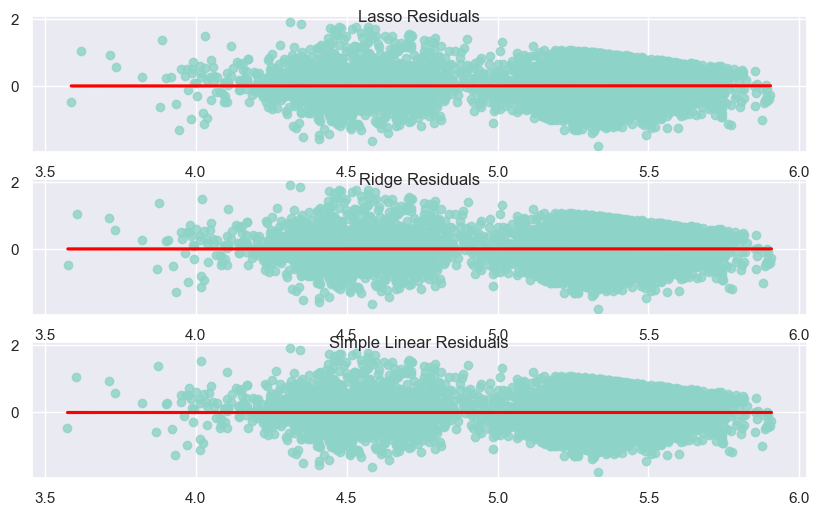

In [86]:
plt.figure(figsize = (10, 6))

# First subplot
plt.subplot(311)
ax = plt.gca()
ax = sns.regplot(x = lasso_pred, y = lasso_resid, line_kws=dict(color='red'));
plt.title('Lasso Residuals', y = .9)

# Second subplot
plt.subplot(312, sharex=ax)
ax = plt.gca()
ax = sns.regplot(x = ridge_pred, y = ridge_resid, line_kws=dict(color='red'));
plt.title('Ridge Residuals', y = .9)

# Third subplot
plt.subplot(313, sharex=ax)
ax = plt.gca()
ax = sns.regplot(x = linear_pred, y = linear_resid, line_kws=dict(color='red'));
plt.title('Simple Linear Residuals', y = .9)

The Lasso Regression actually shows the most promise out of these models since it has the best MSE and it seems to be able to predict outliers to a degree.None of the models seem overwhelmings good at predicting however and they all tend to under predict at higher value which could be expected.

In [87]:
x = X_train.copy()
x['pred'] = lasso_search.predict(X_train)
x['resid'] = y_train-lasso_pred
x = x.join(auck_listings[['suburb']])
x_group = x.groupby('suburb')['resid'].mean().sort_values(ascending=True).to_frame('mean_resid')
new_map = pd.merge(auck_map,x_group, left_on='suburb', right_index=True) 


/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_57593/2262878440.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


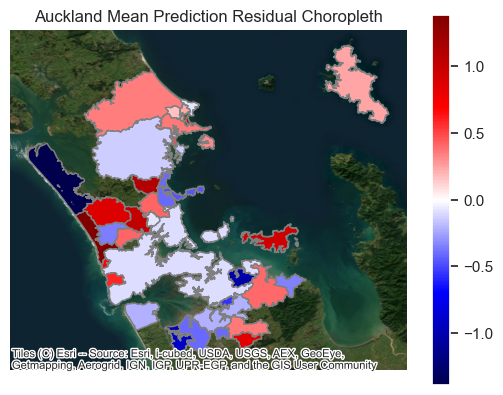

In [88]:
new_map.geometry = new_map.geometry.to_crs(epsg = 4326)

ax = new_map.plot(column = 'mean_resid', edgecolor = 'grey', cmap = 'seismic')
# title
plt.title('Auckland Mean Prediction Residual Choropleth')

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=new_map['mean_resid'].min()-1,\
                                                           vmax=new_map['mean_resid'].max()+1))
sm._A = []
cbar = plt.colorbar(sm)

# add background
contextily.add_basemap(ax=ax, crs=new_map.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('nonweighted_residual.png', dpi=300, bbox_inches='tight')

In [89]:
x_group2 = x.groupby('suburb')['pred'].mean().sort_values(ascending=True).to_frame('mean_pred')
new_map = pd.merge(auck_map,x_group2, left_on='suburb', right_index=True) 

/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_57593/3413409619.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


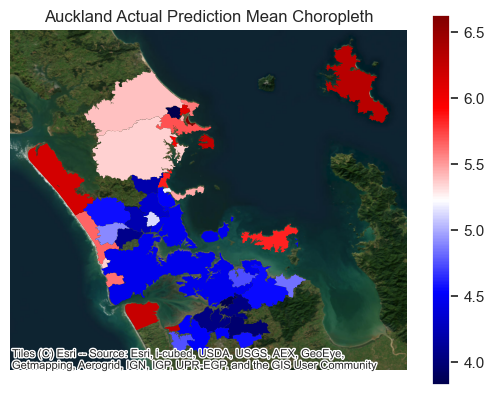

In [90]:
new_map.geometry = new_map.geometry.to_crs(epsg = 4326)

ax = new_map.plot(column = 'mean_pred',edgecolor = 'None', cmap = 'seismic')
 
# title
plt.title('Auckland Actual Prediction Mean Choropleth')

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=new_map['mean_pred'].min()-1,\
                                                           vmax=new_map['mean_pred'].max()+1))
sm._A = []
cbar = plt.colorbar(sm)

# add background
contextily.add_basemap(ax=ax, crs=new_map.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('nonweighted_actual_predictions.png', dpi=300, bbox_inches='tight')

#### Spatial Regression


Lastly, we can try to add some weights on certain aspects of the dataframe. It is important to not that doing this violates the assumption that all variables are independent. However, in spacial data we are operating under the assumption the nearer things are more alike the further things.

To accomplish the we are going to two different features in our dataset. 
1. Room Type should provide a much more significant coefficient depending on where it is listing. hotels rooms near the city center and on the beach will cost much more than hotel rooms elswhere. 
2. Second listing within a 100 meter to the beach will coast much more than listing further away.

To do this we will create a weighted matrix for each feature based on a scaled average of the 15 nearest neighbors.

In [91]:
# Create Geo dataframe with dummy variable to manually create spatial lag
rt = pd.get_dummies(auck_listings['room_type'], prefix='rt').rename(columns=lambda x: x.replace(' ', '_'))
# suburb = pd.get_dummies(auck_listings['suburb'], prefix='suburb', drop_first=1).rename(columns=lambda x: x.replace(' ', '_'))
coastal = pd.get_dummies(auck_listings['is_coastal'], prefix='coastal').rename(columns=lambda x: x.replace(' ', '_'))
coastal_sub = pd.get_dummies(auck_listings['coastal_suburb'], prefix='coast_sub', drop_first=1).rename(columns=lambda x: x.replace(' ', '_'))
# Standard scale numerical features
num_features_scaled = pd.DataFrame(StandardScaler().fit_transform(auck_listings[num_features]),\
                                   columns=num_features, index=auck_listings[num_features].index)

# # Concatenate encoded categorical features and scaled numerical features
preprocessed = pd.DataFrame(data = pd.concat([auck_listings[['geometry', 'price']],\
                                                num_features_scaled, rt, coastal, coastal_sub],axis=1))

preprocessed = gpd.GeoDataFrame(preprocessed, geometry=preprocessed.geometry).to_crs(epsg=4326)


In [92]:
# DataFrame that contain the string "rt_", which implies that it is only considering variables belonging
# to the same "room type" category. Then, a spatial weights matrix knn is defined using the KNN class with 11
# nearest neighbors, and the row-standardization transformation is applied to it.

knn = KNN.from_dataframe(preprocessed, k=9)

# standardize: make neighbors weight add up to 1
knn.transform = "R"

rt_weights = (
    preprocessed.filter(
        like="rt_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda x: spatial_lag.lag_spatial(knn, x)
    )
    .rename(
        columns = lambda col: "w_" + col
    )
)  


# lets also add a spatial lag for being coastal
coastal_weights = (
    preprocessed.filter(
        like="coastal_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda x: spatial_lag.lag_spatial(knn, x)
    )
    .rename(
        columns = lambda col: "w_" + col
    )
)
coastal_weights.head()




/Users/laffer/Desktop/IoD/iod_env/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


w_coastal_0  w_coastal_1
0          1.0          0.0
1          1.0          0.0
2          1.0          0.0
3          1.0          0.0
4          1.0          0.0

In [93]:
model = preprocessed.join([rt_weights, coastal_weights])

In [94]:
X = model.drop(columns=['price', 'geometry', 'rt_Entire_home/apt', 'w_rt_Entire_home/apt', 'coastal_0', 'w_coastal_0'])
y = np.ravel(np.log(model[['price']]))

# split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=123)
 
X.head()

minimum_nights  number_of_reviews  reviews_per_month  \
0       -0.454359          -0.549342          -0.799571   
1       -0.129711          -0.549342          -0.799571   
2       -0.454359          -0.549342          -0.799571   
3        0.194937          -0.384668          -0.751101   
4       -0.129711           6.119948           1.058427   

   calculated_host_listings_count  availability_365  min_dist  amen_count  \
0                       -0.155332         -1.140273  0.136726   -0.463841   
1                       -0.155332         -1.140273 -0.167735   -0.463841   
2                       -0.155332         -1.140273  0.367128   -0.463841   
3                       -0.155332         -0.613982 -0.198412   -0.463841   
4                       -0.155332          0.386712 -0.196467   -0.463841   

   dist_to_beach  rt_Hotel_room  rt_Private_room  rt_Shared_room  coastal_1  \
0       0.344570              0                1               0          0   
1      -0.467394              0                1               0          0   
2      -0.388115              0                1               0          0   
3      -0.639193              0                1               0          0   
4      -0.798945              0                1               0          0   

   coast_sub_1  w_rt_Hotel_room  w_rt_Private_room  w_rt_Shared_room  \
0            1              0.0           0.555556               0.0   
1            1              0.0           0.333333               0.0   
2            1              0.0           0.222222               0.0   
3            1              0.0           0.444444               0.0   
4            1              0.0           0.555556               0.0   

   w_coastal_1  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

#### Weighted Ridge Regression


In [95]:
ridge_pipeline = Pipeline([
    ('Ridge', Ridge(max_iter=10000, random_state=123))])

ridge_grid = {'Ridge__alpha': [0.01, 0.1, 1.0, 10, 50],
             'Ridge__fit_intercept': [True,False]}

ridge_search = GridSearchCV(ridge_pipeline, ridge_grid, cv=5, scoring='r2', n_jobs=6)

ridge_search.fit(X_train, y_train)


n = X_train.shape[0]  # number of observations
k = len(X_train.columns) - 1  # number of independent variables
r2 = ridge_search.best_score_  # R-squared score
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)



print("Ridge best params: " + str(ridge_search.best_params_))
print()
print("Ridge best score: " + str(adjusted_r2))
print()
print(f'Ridge Best Estimators: {ridge_search.best_estimator_}')

# Get the best estimator
best_estimator = ridge_search.best_estimator_

# Get the feature names and coefficients
feature_names = X_train.columns
coefficients = best_estimator.named_steps['Ridge'].coef_

# Create a dataframe with feature names and coefficients
w_ridge_coef_df = pd.DataFrame({'Ridge Feature': feature_names, 'Ridge Coefficient': coefficients})

w_ridge_coef_df.sort_values('Ridge Coefficient')



Ridge best params: {'Ridge__alpha': 1.0, 'Ridge__fit_intercept': True}

Ridge best score: 0.44123989729176505

Ridge Best Estimators: Pipeline(steps=[('Ridge', Ridge(max_iter=10000, random_state=123))])


Ridge Feature  Ridge Coefficient
10                  rt_Shared_room          -1.210832
9                  rt_Private_room          -0.768151
15                w_rt_Shared_room          -0.457496
14               w_rt_Private_room          -0.303772
8                    rt_Hotel_room          -0.247623
13                 w_rt_Hotel_room          -0.069797
1                number_of_reviews          -0.068718
2                reviews_per_month          -0.066925
12                     coast_sub_1          -0.063485
7                    dist_to_beach          -0.027801
5                         min_dist          -0.003576
6                       amen_count          -0.003007
0                   minimum_nights           0.002279
3   calculated_host_listings_count           0.005388
11                       coastal_1           0.095687
4                 availability_365           0.107074
16                     w_coastal_1           0.167747

In [96]:
%%time

lasso_pipeline = Pipeline([('Lasso', Lasso(max_iter=10000, random_state=123))])



lasso_grid = {'Lasso__alpha': [.0001,.005, .001],
              'Lasso__fit_intercept': [True,False]}

lasso_search = GridSearchCV(lasso_pipeline, lasso_grid, cv=5, scoring='r2',n_jobs=6)

lasso_search.fit(X_train, y_train)
#--------------------------------------------------------------------------------------------------------

n = X_train.shape[0]  # number of observations
k = len(X_train.columns) - 1  # number of independent variables
r2 = lasso_search.best_score_  # R-squared score
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)





print("Lasso best params: " + str(lasso_search.best_params_))
print()
print("Lasso Adjusted R Squared: " + str(adjusted_r2))
print()

# Get the best estimator
best_estimator = lasso_search.best_estimator_

# Get the feature names and coefficients
feature_names = X_train.columns
coefficients = best_estimator.named_steps['Lasso'].coef_.round(2)

# Create a dataframe with feature names and coefficients
w_lasso_coef_df = pd.DataFrame({'Lasso Feature': feature_names, 'Lasso Coefficient': coefficients})

w_lasso_coef_df.sort_values('Lasso Coefficient')

Lasso best params: {'Lasso__alpha': 0.0001, 'Lasso__fit_intercept': True}

Lasso Adjusted R Squared: 0.4412304135133771

CPU times: user 358 ms, sys: 493 ms, total: 851 ms
Wall time: 147 ms


Lasso Feature  Lasso Coefficient
10                  rt_Shared_room              -1.23
9                  rt_Private_room              -0.77
15                w_rt_Shared_room              -0.44
14               w_rt_Private_room              -0.30
8                    rt_Hotel_room              -0.25
1                number_of_reviews              -0.07
2                reviews_per_month              -0.07
12                     coast_sub_1              -0.06
13                 w_rt_Hotel_room              -0.04
7                    dist_to_beach              -0.03
0                   minimum_nights               0.00
5                         min_dist              -0.00
6                       amen_count              -0.00
3   calculated_host_listings_count               0.01
11                       coastal_1               0.09
4                 availability_365               0.11
16                     w_coastal_1               0.16

In [97]:
pd.merge(w_lasso_coef_df,w_ridge_coef_df, left_on='Lasso Feature', right_on='Ridge Feature').round(2)

Lasso Feature  Lasso Coefficient  \
0                   minimum_nights               0.00   
1                number_of_reviews              -0.07   
2                reviews_per_month              -0.07   
3   calculated_host_listings_count               0.01   
4                 availability_365               0.11   
5                         min_dist              -0.00   
6                       amen_count              -0.00   
7                    dist_to_beach              -0.03   
8                    rt_Hotel_room              -0.25   
9                  rt_Private_room              -0.77   
10                  rt_Shared_room              -1.23   
11                       coastal_1               0.09   
12                     coast_sub_1              -0.06   
13                 w_rt_Hotel_room              -0.04   
14               w_rt_Private_room              -0.30   
15                w_rt_Shared_room              -0.44   
16                     w_coastal_1               0.16   

                     Ridge Feature  Ridge Coefficient  
0                   minimum_nights               0.00  
1                number_of_reviews              -0.07  
2                reviews_per_month              -0.07  
3   calculated_host_listings_count               0.01  
4                 availability_365               0.11  
5                         min_dist              -0.00  
6                       amen_count              -0.00  
7                    dist_to_beach              -0.03  
8                    rt_Hotel_room              -0.25  
9                  rt_Private_room              -0.77  
10                  rt_Shared_room              -1.21  
11                       coastal_1               0.10  
12                     coast_sub_1              -0.06  
13                 w_rt_Hotel_room              -0.07  
14               w_rt_Private_room              -0.30  
15                w_rt_Shared_room              -0.46  
16                     w_coastal_1               0.17

In [98]:
# predict and get residuals


lasso_pred = lasso_search.predict(X_train)
lasso_resid = y_train-lasso_pred

ridge_pred = ridge_search.predict(X_train)
ridge_resid = y_train-ridge_pred

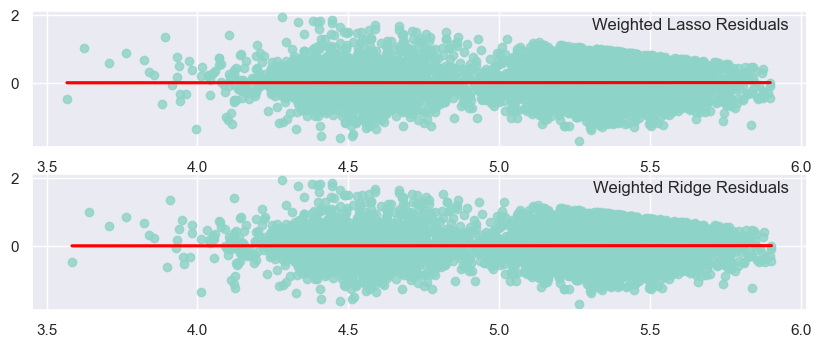

In [99]:
plt.figure(figsize = (10, 6))

# First subplot
plt.subplot(311)
ax = plt.gca()
ax = sns.regplot(x = lasso_pred, y = lasso_resid, line_kws=dict(color='red'));
plt.title('Weighted Lasso Residuals', x = .85, y = .8)

# Second subplot
plt.subplot(312, sharex=ax)
ax = plt.gca()
ax = sns.regplot(x = ridge_pred, y = ridge_resid, line_kws=dict(color='red'));
plt.title('Weighted Ridge Residuals',x = .85, y = .8);


In [100]:
x = X_train.copy()
x['pred'] = lasso_search.predict(X_train)
x['resid'] = y_train-lasso_pred
x = x.join(auck_listings[['suburb']])
x_group = x.groupby('suburb')['resid'].mean().sort_values(ascending=True).to_frame('mean_resid')
new_map = pd.merge(auck_map,x_group, left_on='suburb', right_index=True)


/var/folders/nf/vsypdynx6l5bkkj3kvftrpz80000gn/T/ipykernel_57593/1028347632.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


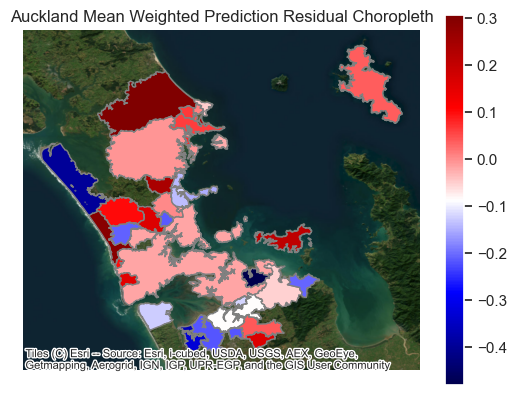

In [101]:
# Mapping residuals based on weighted lasso regression
new_map.geometry = new_map.geometry.to_crs(epsg = 4326)

ax = new_map.plot(column = 'mean_resid', edgecolor = 'grey', cmap = 'seismic')
# title
plt.title('Auckland Mean Weighted Prediction Residual Choropleth')

sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=new_map['mean_resid'].min(),\
                                                           vmax=new_map['mean_resid'].max()))
sm._A = []
cbar = plt.colorbar(sm)

# add background
contextily.add_basemap(ax=ax, crs=new_map.crs.to_string(), source= contextily.providers.Esri.WorldImagery)
ax.set_axis_off() 
plt.savefig('weighted_residual.png', dpi=300, bbox_inches='tight')

Our predictions from a geospatial aspect are much closer than they were before even if the adjusted R Squared isn't telling. Red areas respresent under predicting and blue areas respresent over predicting. 

### Conclusion

Here's a brief recap of what we've covered:

- The rise of Airbnb and other short-term rental platforms has disrupted the traditional housing market, making it challenging for homeowners and potential renters to estimate fair rental prices.
- In this notebook, we explored the power of geospatial data and machine learning algorithms to analyze factors that influence rental prices in New Zealand and predict housing prices for AirBnB listings.
- While limited data and minimal correlation hindered our ability to make better predictions, we found that spatial influence was a crucial factor in developing a more accurate model.
- By incorporating geospatial data into our analysis, we were able to identify patterns and relationships between the location of AirBnB listings and their corresponding rental prices.
- Our findings suggest that geospatial techniques can be a valuable tool in predicting housing prices in the context of short-term rentals, despite the limitations of the data.
- Further inclusion of geospatial feature engineering could help improve predictions. For instance, the inclusion of percent rural area in each suburb may influence predictions. There are many more factors to consider.

Although we are far from happy with the results. Overall, our analysis has demonstrated the potential of geospatial techniques to make informed decisions in the housing market. Despite the challenges of limited data and minimal correlation, we were able to leverage the spatial influence of AirBnB listings to create a more accurate model of housing prices in New Zealand. We hope that this notebook has provided you with a deeper understanding of how geospatial techniques can be used to analyze the complex dynamics of the housing market and make more informed decisions in the future.








### Sources

1. Inside Airbnb. (http://insideairbnb.com/new-zealand/)
2. LINZ Data Service. (https://data.linz.govt.nz/)
3. OpenStreetMap. (https://www.openstreetmap.org/)
4. Yelp. (https://www.yelp.com/)